In [28]:
# %load Notched_gmsh.py
#!/usr/bin/env python3
"""
FEniCS project to simulate stress field in unnotched ice strip with Finite
Element Method.

Created on Wed Apr 28 10:11:10 2021

@author: Hanwen Zhang

"""

from fenics import *
from dolfin import *
from mshr import *
import numpy as np
import math
import matplotlib.pyplot as plt
from ufl import nabla_div

# Dimensional parameters
# half length of strip
L_dim = 1000.0 # (m)
# half width of sticky patch
w_dim = 100.0 # (m)
# ice thickeness
H_dim = 100.0 # (m)

# density of w-water i-ice
rho_w_dim = 1000 # (kg/m^3)
rho_i_dim = 917 # (kg/m^3)
# gravitational acceleration
g = 9.8 # (m/s^2)
# characteristic stress and pressure
sigma_dim = rho_i_dim * g * H_dim 
E_dim = 1e10 # Pa
gnu = 0.33 # Poisson ratio
# SIF dimensional
K1c_dim = 1E5 # Pa m^1/2

# Scaled diemensionless parameters
Len = L_dim / H_dim
w = w_dim / H_dim
H = H_dim / H_dim

# crack length for a specific basal cracks
rho_w = rho_w_dim / rho_i_dim
rho_i=1
fl = 0.7 # flotation fraction
deltatau = 0.3 # friction excess
f_excess = Constant((-deltatau,0.0))

# Material Properties
E = E_dim / sigma_dim
ilambda = E * gnu / ((1.0 + gnu)*(1.0 - 2.0 * gnu))
imu = E / (2.0 * (1 + gnu)) # shear modulus
kappa=(3-gnu) / (1+gnu) # material properties
K1c = K1c_dim /(rho_i_dim*g*(H_dim**1.5))

The MeshValueCollection:  <dolfin.cpp.mesh.MeshValueCollection_sizet object at 0x40fe5ffdf8>
Plotting an Unnotched Rectangle Mesh


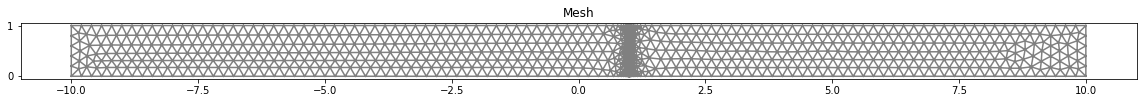

In [29]:
# Initialize parameters
f_base = Constant((deltatau * w / Len, 0))

####################### Mesh Generation and Function Space#####################
# read the mesh
mesh = Mesh()
# XDMFFile(MPI.comm_world, "./mesh.xdmf").read(mesh)

with XDMFFile(MPI.comm_world, "./Unnotched_Mesh/Unnotched_mesh.xdmf") as meshfile, \
        XDMFFile(MPI.comm_world, "./Unnotched_Mesh/Unnotched_facet_mesh.xdmf") as boundaryfile:
    meshfile.read(mesh)
    mvc = MeshValueCollection("size_t", mesh, mesh.topology().dim() - 1)
    print("The MeshValueCollection: ", mvc)
    boundaryfile.read(mvc, "Boundaries")
    boundaries = MeshFunction("size_t", mesh, mvc) # Mark boundaries

print("Plotting an Unnotched Rectangle Mesh")
fig = plt.figure()
plot(mesh,title='Mesh')
fig.set_size_inches(20, 4)

#################### Create Function Space and Boundary Conditions################
order = 3
V = VectorFunctionSpace(mesh, 'P', order)
# Quadrilateral elements, 2nd order
# Create test and trial functions
u, wv = TrialFunction(V), TestFunction(V)

#Define Boundary Conditions
# g3-g5 are (zero) stress on boudanry 3-5
f0 = Constant((0.0,0.0))
tol = 1e-14 # tolerance

boundary_conditions = {1: {'mixed': f_base},
              2: {'mixed': f_excess+f_base},
              3: {'mixed': f_base},
              4: {'Neumann': f0},
              5: {'Neumann': f0},
              6: {'Neumann': f0}}
# Schematic:
#                        5
#       ___________________________________
#      |                                   |
#   5  |                                   |  4
#      |                                   |
#      |_________ _________________________|
#
#           1           2              3
#
# Define strain and stress

def epsilon(u):
    return 0.5*(nabla_grad(u) + nabla_grad(u).T)
    #return sym(nabla_grad(u))
def sigma(u):
    return ilambda * nabla_div(u) * Identity(d) + 2 * imu * epsilon(u) 

# Redefine boundary integration measure
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

# Collect Dirichlet conditions
bcs = []
for i in boundary_conditions:
    if 'mixed' in boundary_conditions[i]:
        bc = DirichletBC(V.sub(1), Constant(0.0), boundaries, i)
        bcs.append(bc)

# Collect Neumann Boundary Conditions
integrals_N = []
for i in boundary_conditions:
    # Zero Neumann Boundary Conditions
    if ('Neumann' in boundary_conditions[i]):
        if boundary_conditions[i]['Neumann'] != 0:
            t = boundary_conditions[i]['Neumann']
            integrals_N.append(dot(t,wv)*ds(i))
    # Zero displacement in z, friction in x
    if ('mixed' in boundary_conditions[i]):
        if boundary_conditions[i]['mixed'] != 0:
            t = boundary_conditions[i]['mixed']
            integrals_N.append(dot(t,wv)*ds(i))

########################### Set up PDE and solve########################
uh = Function(V)
d = u.geometric_dimension()  # space dimension
f = Constant((0,0))
a = inner(sigma(u), epsilon(wv)) * dx
L = dot(f,wv)*dx + sum(integrals_N)

# Compute Solution
solve(a == L, uh, bcs)

# Save solution to file in vtk format
File('UnNotched_Results/displacement.pvd') << uh

W = TensorFunctionSpace(mesh, "Discontinuous Lagrange", order)
stress = project(sigma(uh), V=W)
File('UnNotched_Results/stress.pvd') << stress



In [35]:
######################## Weight Function ###################
# Use Scipy to integrate numerically

from scipy.integrate import simps 

tol = 1E-14
vlambda = np.arange(0,1.0,1E-4)
sigmaxx_net = np.zeros(np.shape(vlambda))
sigmaxz_net = np.zeros(np.shape(vlambda))
sigmazz_net = np.zeros(np.shape(vlambda))
dK1 = np.zeros(np.shape(vlambda)) # K1
dK2 = np.zeros(np.shape(vlambda)) # K2
Nlambda = np.shape(vlambda)[0]

# constant
pi=math.pi

def phi(lam,gamma):
    return np.sqrt(np.tan(0.5*pi*lam) / (1.0-(np.cos(0.5*pi*lam)/np.cos(0.5*pi*gamma*lam))**2))
    # return np.sqrt(np.tan(0.5*pi*lam) / (1.0-(np.cos(0.5*pi*lam)/np.cos(0.5*pi*gamma*lam))**2)) * (1+np.sin(0.5*pi*lam*gamma)/np.sin(0.5*pi*lam))return np.sqrt(np.tan(0.5*pi*lam) / (1.0-(np.cos(0.5*pi*lam)/np.cos(0.5*pi*gamma*lam))**2)) * (1+np.sin(0.5*pi*lam*gamma)/np.sin(0.5*pi*lam))
def greens1(lam,gamma):
    return 2.0/np.sqrt(2)*(1+0.297*np.sqrt(1.0-gamma**2)*(1-np.cos(0.5*pi*lam)))*phi(lam,gamma)

def greens2(lam,gamma):
    return 2.0/np.sqrt(2)*(1+0.297*np.sqrt(1.0-gamma**2)*(1-np.cos(0.5*pi*lam)))*phi(lam,gamma)*np.sin(0.5*pi*lam*gamma)/np.sin(0.5*pi*lam)

for i, ilambda in enumerate(vlambda):    
    # sigma_{net} in weight function
    sigmaxx_net[i] = stress(w,ilambda)[0] + max([fl - rho_w*ilambda,0]) + (-1.0 + rho_i*ilambda)
    sigmaxz_net[i] = stress(w,ilambda)[1]
    sigmazz_net[i] = stress(w,ilambda)[3] + max([fl - rho_w*ilambda,0]) + (-1.0 + rho_i*ilambda)
    if(i%10==0 and i!=0):
        stress_net=[vlambda[i], stress(w,ilambda)[0], sigmaxz_net[i], stress(w,ilambda)[3]]
        print(stress_net)
        with open('Stress_net.txt','ab') as fs:
                np.savetxt(fs, np.matrix(stress_net), delimiter=" ")
                


[0.001, 1.255664787935749, 0.12029810402211349, -0.12995958278126304]
[0.002, 1.1315254895735294, 0.11976872515239256, -0.1241006745267348]
[0.0030000000000000001, 1.0650621276157788, 0.11969249808957687, -0.11322874549753097]
[0.0040000000000000001, 1.0171254065252362, 0.11953948453786305, -0.10600372136477881]
[0.0050000000000000001, 0.97979797373595101, 0.1193707455560145, -0.10050622921427013]
[0.0060000000000000001, 0.94936377706076924, 0.11924315513351563, -0.096156993728888779]
[0.0070000000000000001, 0.92377209444406017, 0.1191328847367019, -0.092385393572662303]
[0.0080000000000000002, 0.90148572878540278, 0.11900008858788913, -0.089177751919579384]
[0.0090000000000000011, 0.88184891130198939, 0.11889434239703936, -0.086307793731734778]
[0.01, 0.86427314131462085, 0.11876675341752492, -0.083765498961515999]
[0.011000000000000001, 0.84838090337987393, 0.118640262247797, -0.081462533154826558]
[0.012, 0.83388224849641412, 0.11852010563307555, -0.079345491499561355]
[0.0130000000

[0.112, 0.46182961054947358, 0.10616828760908201, -0.025693232724459437]
[0.113, 0.4603548476507705, 0.10604497238141443, -0.025486283257300721]
[0.114, 0.45889321683624318, 0.10592167413359418, -0.025281288582853813]
[0.115, 0.45744447621197254, 0.1057983729547506, -0.025078226098027283]
[0.11600000000000001, 0.45600840269245663, 0.10567508056674904, -0.024877076572370493]
[0.11700000000000001, 0.45458478896971588, 0.1055517852773299, -0.024677785136165427]
[0.11800000000000001, 0.45317340908762593, 0.10542850246602159, -0.024480343191390863]
[0.11900000000000001, 0.45177407337169095, 0.10530522338077493, -0.024284716149680773]
[0.12000000000000001, 0.45038657592453446, 0.10518195121309284, -0.024090856410514391]
[0.12100000000000001, 0.44901073240502393, 0.10505867264651039, -0.02389874019666114]
[0.12200000000000001, 0.44764633178315921, 0.10493540948710822, -0.023708393164389892]
[0.12300000000000001, 0.44629319563785924, 0.10481214560157259, -0.023519722593696973]
[0.124, 0.444951

[0.22700000000000001, 0.34531169316557891, 0.092028659127010859, -0.010027808383890757]
[0.22800000000000001, 0.34459338864506561, 0.091906120037596975, -0.0099381315158492446]
[0.22900000000000001, 0.3438783458519451, 0.091783590171699847, -0.0098489951592637369]
[0.23000000000000001, 0.34316654022407111, 0.091661069968263745, -0.009760391029758125]
[0.23100000000000001, 0.3424579441013062, 0.091538558800547828, -0.0096723166560734285]
[0.23200000000000001, 0.34175252876490714, 0.091416056791003356, -0.0095847667904112831]
[0.23300000000000001, 0.34105026721725401, 0.091293564351030781, -0.0094977395639520741]
[0.23400000000000001, 0.34035113339528894, 0.091171079837064628, -0.0094112312234608028]
[0.23500000000000001, 0.33965510430717577, 0.091048607530595585, -0.0093252302923950425]
[0.23600000000000002, 0.33896214761544963, 0.09092614284934078, -0.009239742284391686]
[0.23700000000000002, 0.33827224098209308, 0.090803687677127098, -0.009154758446553786]
[0.23800000000000002, 0.3375

[0.32700000000000001, 0.28617428376434828, 0.079825116007112507, -0.0032106457702034082]
[0.32800000000000001, 0.28568484930020754, 0.07970363123153254, -0.0031603553398599168]
[0.32900000000000001, 0.28519700858995412, 0.079582157898499373, -0.0031103558169341128]
[0.33000000000000002, 0.28471075093396114, 0.079460695771432888, -0.0030606463038833397]
[0.33100000000000002, 0.28422606815314916, 0.079339245188931734, -0.0030112250881127898]
[0.33200000000000002, 0.28374294998020083, 0.079217805854610635, -0.0029620908891317419]
[0.33300000000000002, 0.2832613874387423, 0.079096377903514897, -0.0029132420214896138]
[0.33400000000000002, 0.28278137139897452, 0.078974961511519934, -0.0028646778825827746]
[0.33500000000000002, 0.28230289217762372, 0.078853556609100442, -0.0028163960685905669]
[0.33600000000000002, 0.28182594180300991, 0.078732163001122957, -0.0027683965504310313]
[0.33700000000000002, 0.28135051025113023, 0.078610781076039027, -0.0027206763850107668]
[0.33800000000000002, 0

[0.42800000000000005, 0.24347324224157102, 0.067614562775025255, 0.00059571084134127849]
[0.42900000000000005, 0.24310726980469877, 0.067494279802578244, 0.00062224686947317956]
[0.42999999999999999, 0.24274222690386676, 0.06737400911383884, 0.0006485920304393556]
[0.43099999999999999, 0.24237810924216358, 0.067253750737883228, 0.00067474831172376808]
[0.432, 0.24201491275090986, 0.067133504655705209, 0.00070071573968899016]
[0.433, 0.2416526320988196, 0.067013270557876536, 0.00072649480488336932]
[0.434, 0.24129126360088932, 0.066893048787568604, 0.00075208644932862954]
[0.435, 0.24093080282014337, 0.066772839059229525, 0.00077749164059309794]
[0.436, 0.24057124529951995, 0.066652641625801146, 0.0008027106030772291]
[0.437, 0.24021258690373848, 0.066532456282838229, 0.00082774430842575449]
[0.438, 0.23985482323262905, 0.066412283211804063, 0.00085259338286113875]
[0.439, 0.23949795037562355, 0.066292122216177279, 0.00087725869635648897]
[0.44, 0.23914196372618471, 0.066171973380088095

[0.52700000000000002, 0.21114511268813835, 0.055765146045646093, 0.0023974474738909829]
[0.52800000000000002, 0.21085323391773192, 0.055646054083046452, 0.0024080551337622297]
[0.52900000000000003, 0.21056194874677525, 0.055526973686153433, 0.0024185276626353777]
[0.53000000000000003, 0.21027125519559625, 0.055407905107301446, 0.0024288658434438812]
[0.53100000000000003, 0.20998115021351146, 0.055288848143359173, 0.0024390698104920479]
[0.53200000000000003, 0.20969163162157034, 0.055169802716956567, 0.002449140483105296]
[0.53300000000000003, 0.20940269671002307, 0.055050768957195642, 0.0024590778981231831]
[0.53400000000000003, 0.20911434270944382, 0.054931746785262199, 0.0024688827546457751]
[0.53500000000000003, 0.20882656743532257, 0.05481273617050441, 0.0024785553389349195]
[0.53600000000000003, 0.20853936800148976, 0.054693737144795682, 0.0024880963751751023]
[0.53700000000000003, 0.20825274209077504, 0.054574749610241419, 0.0024975060109396416]
[0.53800000000000003, 0.2079666871

[0.63, 0.18378676847503478, 0.043555389271528119, 0.002857486807362176]
[0.63100000000000001, 0.1835441270185002, 0.043437352335678636, 0.0028564213472432845]
[0.63200000000000001, 0.18330185904623855, 0.043319323827647513, 0.0028552632746465679]
[0.63300000000000001, 0.18305996289663584, 0.043201303878633329, 0.0028540132563907462]
[0.63400000000000001, 0.18281843642419116, 0.04308329222110141, 0.002852671102656688]
[0.63500000000000001, 0.1825772780397909, 0.042965289016827821, 0.0028512376421334375]
[0.63600000000000001, 0.18233648596701421, 0.042847294219524476, 0.0028497132608837706]
[0.63700000000000001, 0.18209605837506987, 0.042729307701545691, 0.0028480982071805924]
[0.63800000000000001, 0.18185599348808407, 0.042611329497289754, 0.00284639288389922]
[0.63900000000000001, 0.18161628963413731, 0.042493359541817391, 0.0028445978476198085]
[0.64000000000000001, 0.18137694477434735, 0.04237539782533787, 0.0028427132142084624]
[0.64100000000000001, 0.18113795735380403, 0.0422574442

[0.72799999999999998, 0.16152160735626542, 0.032021981384188845, 0.0023725837755119153]
[0.72899999999999998, 0.16130750934276541, 0.031904573523038077, 0.002364317211999185]
[0.72999999999999998, 0.16109362273064864, 0.031787169543332473, 0.002355997422987983]
[0.73099999999999998, 0.16087994577197001, 0.031669769385258492, 0.0023476247018085023]
[0.73199999999999998, 0.16066647698051612, 0.031552372968070189, 0.002339199527239245]
[0.73299999999999998, 0.16045321479595714, 0.031434980185354205, 0.0023307224118071799]
[0.73399999999999999, 0.1602401575812086, 0.031317591080657355, 0.0023221936833515483]
[0.73499999999999999, 0.16002730388819211, 0.031200205546920108, 0.0023136138276894616]
[0.73599999999999999, 0.15981465202003831, 0.031082823523980917, 0.0023049833755639437]
[0.73699999999999999, 0.15960220060290922, 0.030965444954191818, 0.0022963026422540673]
[0.73799999999999999, 0.15938994783761776, 0.030848069784455538, 0.0022875720910766873]
[0.73899999999999999, 0.159177892250

[0.82900000000000007, 0.1407028443711455, 0.020172891513702201, 0.0013459395835958268]
[0.83000000000000007, 0.14050211955189595, 0.020055552623438885, 0.0013347009790198785]
[0.83100000000000007, 0.14030144494105395, 0.019938210900569457, 0.0013234600720439325]
[0.83200000000000007, 0.1401008187918375, 0.019820866304238037, 0.0013122175606265997]
[0.83300000000000007, 0.13990023924705872, 0.019703518710550517, 0.0013009739871780895]
[0.83400000000000007, 0.13969970496335349, 0.019586168100531324, 0.001289729958933487]
[0.83500000000000008, 0.13949921394335602, 0.019468814311480048, 0.001278486090893458]
[0.83600000000000008, 0.13929876460059581, 0.019351457399576256, 0.0012672430731114524]
[0.83700000000000008, 0.13909835521819622, 0.019234097219862918, 0.0012560013784349562]
[0.83800000000000008, 0.13889798418611921, 0.01911673361253494, 0.001244761724665122]
[0.83900000000000008, 0.13869764976796631, 0.018999366700208613, 0.0012335246632408786]
[0.84000000000000008, 0.13849735021572

[0.93000000000000005, 0.12038718535501146, 0.0082941848141751748, 0.00031202098200280084]
[0.93100000000000005, 0.12018236369318258, 0.008176153301299751, 0.00030411603083255136]
[0.93200000000000005, 0.11997740032956904, 0.0080581106090735245, 0.00029628647111283986]
[0.93300000000000005, 0.11977229268206371, 0.007940056659116174, 0.0002885333611036607]
[0.93400000000000005, 0.11956703868000464, 0.0078219912378936635, 0.00028085755557220242]
[0.93500000000000005, 0.11936163612775628, 0.0077039144523670822, 0.00027326016306755571]
[0.93600000000000005, 0.11915608279120832, 0.0075858260179375346, 0.00026574219376614421]
[0.93700000000000006, 0.11895037641310988, 0.0074677260054776635, 0.00025830467643965705]
[0.93800000000000006, 0.11874451464295883, 0.0073496141313310181, 0.0002509484278246568]
[0.93900000000000006, 0.11853849539170275, 0.0072314905881430136, 0.00024367459737942597]
[0.94000000000000006, 0.11833231652828978, 0.0071133549613920204, 0.00023648426575856329]
[0.94100000000

TypeError: expected scalar arguments for the coordinates

In [44]:
# Lateral boundaries
vlambda = np.arange(0,1.0,1E-4)
sigmaxx_lateral = np.zeros(np.shape(vlambda))
sigmaxz_lateral = np.zeros(np.shape(vlambda))
sigmazz_lateral = np.zeros(np.shape(vlambda))
for i, ilambda in enumerate(vlambda):    
    # sigma_{net} in weight function
    sigmaxx_lateral[i] = stress(Len,ilambda)[0]
    sigmaxz_lateral[i] = stress(Len,ilambda)[1]
    sigmazz_lateral[i] = stress(Len,ilambda)[3]
    if(i%10==0 and i!=0):
        stress_lateral=[vlambda[i], sigmaxx_lateral[i], sigmaxz_lateral[i], sigmazz_lateral[i]]
        print(stress_lateral)
        with open('Stress_lateral.txt','ab') as fs:
                np.savetxt(fs, np.matrix(stress_lateral), delimiter=" ") 

[0.001, 0.0086994504532062981, -0.020531174626239566, 0.14024771529227004]
[0.002, 0.0085336767065661914, -0.020243877996709698, 0.13922097021767069]
[0.0030000000000000001, 0.0083691649977837776, -0.019958474335089325, 0.13819903571049572]
[0.0040000000000000001, 0.0082059153268590635, -0.019674963641378478, 0.13718191177074521]
[0.0050000000000000001, 0.008043927693792044, -0.019393345915577138, 0.13616959839841913]
[0.0060000000000000001, 0.0078832020985827259, -0.019113621157685303, 0.1351620955935175]
[0.0070000000000000001, 0.0077237385412311076, -0.018835789367702992, 0.13415940335604032]
[0.0080000000000000002, 0.0075655370217371821, -0.018559850545630186, 0.13316152168598755]
[0.0090000000000000011, 0.0074085975401009573, -0.018285804691466897, 0.1321684505833593]
[0.01, 0.007252920096322427, -0.01801365180521311, 0.13118019004815543]
[0.011000000000000001, 0.0070985046904015981, -0.01774339188686885, 0.13019674008037604]
[0.012, 0.0069453513223384665, -0.017475024936434099, 0

[0.108, -0.0018813237462829034, -0.00052545628138507333, 0.05766672017413528]
[0.109, -0.0019120594421493814, -0.00044070721817297516, 0.057154705813950969]
[0.11, -0.0019415331001581611, -0.0003578511228703921, 0.056647502021191107]
[0.111, -0.0019697447203092448, -0.00027688799547731686, 0.056145108795855672]
[0.112, -0.0019966943026026298, -0.00019781783599375662, 0.055647526137944679]
[0.113, -0.0020223818470383177, -0.000120640644419708, 0.055154754047458142]
[0.114, -0.0020468073536163076, -4.5356420755171892e-05, 0.054666792524396046]
[0.115, -0.0020699708223366007, 2.8034834999854765e-05, 0.054183641568758364]
[0.11600000000000001, -0.0020918722531991962, 9.9533122845367624e-05, 0.053705301180545145]
[0.11700000000000001, -0.0021125116462040938, 0.00016913844278136791, 0.053231771359756354]
[0.11800000000000001, -0.0021318890013512933, 0.00023685079480785542, 0.052763052106392004]
[0.11900000000000001, -0.002150004318640797, 0.00030267017892483263, 0.052299143420452096]
[0.1200

[0.21400000000000002, -0.00078666202055586434, 0.00016793121295963247, 0.02926718561937848]
[0.215, -0.00077438478282113867, 0.00016965918035859835, 0.029119758348699506]
[0.216, -0.00076220201231934738, 0.00017136347710993896, 0.02897275630518735]
[0.217, -0.00075011370905049102, 0.00017304410321365157, 0.028826179488842047]
[0.218, -0.00073811987301456979, 0.00017470105866973916, 0.028680027899663577]
[0.219, -0.00072622050421158315, 0.00017633434347819949, 0.028534301537651935]
[0.22, -0.00071441560264153144, 0.00017794395763903268, 0.028389000402807132]
[0.221, -0.00070270516830441487, 0.00017952990115223966, 0.028244124495129169]
[0.222, -0.00069108920120023246, 0.0001810921740178199, 0.028099673814618017]
[0.223, -0.00067956770132898594, 0.00018263077623577531, 0.027955648361273722]
[0.224, -0.00066814066869067381, 0.00018414570780610375, 0.02781204813509626]
[0.22500000000000001, -0.00065680810328529638, 0.0001856369687288056, 0.027668873136085625]
[0.22600000000000001, -0.00064

[0.32200000000000001, -6.5520171031806823e-06, 0.00021778269006243113, 0.015802002956020841]
[0.32300000000000001, -4.4772405254210953e-06, 0.00021695422751774081, 0.01570050021936004]
[0.32400000000000001, -2.4969311805966523e-06, 0.00021610209432542524, 0.015599422709866065]
[0.32500000000000001, -6.1108906870717797e-07, 0.0002152262904854839, 0.015498770427538928]
[0.32600000000000001, 1.1802858102476501e-06, 0.00021432681599791513, 0.015398543372378622]
[0.32700000000000001, 2.8771934562673119e-06, 0.00021340367086272163, 0.015298741544385146]
[0.32800000000000001, 4.4796338693522194e-06, 0.00021245685507990058, 0.015199364943558516]
[0.32900000000000001, 5.9876070495022877e-06, 0.00021148636864945294, 0.01510041356989872]
[0.33000000000000002, 7.4011129967175922e-06, 0.00021049221157137875, 0.015001887423405752]
[0.33100000000000002, 8.7201517109979339e-06, 0.00020947438384567841, 0.014903786504079626]
[0.33200000000000002, 9.9447231923433195e-06, 0.00020843288547235187, 0.0148061

[0.41300000000000003, -0.00016682263814173383, -2.8242553136732413e-05, 0.0083720137161213751]
[0.41400000000000003, -0.00016436826521994236, -2.6549167358730474e-05, 0.008306373730993917]
[0.41500000000000004, -0.00016193276370407629, -2.4870807230522813e-05, 0.0082409530991785079]
[0.41600000000000004, -0.0001595161335941356, -2.3207472752109334e-05, 0.0081757518206751496]
[0.41700000000000004, -0.00015711837489011991, -2.155916392349243e-05, 0.0081107698954838436]
[0.41800000000000004, -0.00015473948759202978, -1.9925880744668796e-05, 0.0080460073236045832]
[0.41900000000000004, -0.00015237947169986486, -1.8307623215640514e-05, 0.0079814641050373787]
[0.42000000000000004, -0.00015003832721362557, -1.6704391336405556e-05, 0.0079171402397822162]
[0.42100000000000004, -0.0001477160541333113, -1.5116185106966292e-05, 0.0078530357278391114]
[0.42200000000000004, -0.00014541265245892243, -1.354300452732173e-05, 0.0077891505692080512]
[0.42300000000000004, -0.00014312812219045897, -1.19848

[0.504, -2.0753109522926785e-05, 6.4325516752480899e-05, 0.0032970268823663438]
[0.505, -2.0016034540340182e-05, 6.4651568399172769e-05, 0.0032513480486354102]
[0.50600000000000001, -1.9297830963678846e-05, 6.4962594396069669e-05, 0.0032058885682165281]
[0.50700000000000001, -1.8598498792942849e-05, 6.5258594743172331e-05, 0.0031606484411096933]
[0.50800000000000001, -1.7918038028132086e-05, 6.553956944047963e-05, 0.0031156276673149105]
[0.50900000000000001, -1.7256448669246855e-05, 6.5805518487993341e-05, 0.0030708262468321754]
[0.51000000000000001, -1.6613730716286814e-05, 6.6056441885711906e-05, 0.0030262441796614901]
[0.51100000000000001, -1.5989884169252037e-05, 6.6292339633635433e-05, 0.0029818814658028568]
[0.51200000000000001, -1.5384909028142758e-05, 6.6513211731765115e-05, 0.0029377381052562712]
[0.51300000000000001, -1.4798805292958735e-05, 6.6719058180099935e-05, 0.002893814098021735]
[0.51400000000000001, -1.4231572963699933e-05, 6.6909878978639635e-05, 0.00285010944409925

[0.59400000000000008, -2.9996341821065558e-05, 3.3492437527284026e-05, 6.4441861341571298e-05]
[0.59499999999999997, -3.0957693371758374e-05, 3.2466180692460638e-05, 3.8504825695118218e-05]
[0.59599999999999997, -3.193791632837659e-05, 3.1424898207842077e-05, 1.2787143360711501e-05]
[0.59699999999999998, -3.2937010690920114e-05, 3.0368590073428793e-05, -1.2711185661645648e-05]
[0.59799999999999998, -3.3954976459388838e-05, 2.9297256289220465e-05, -3.7990161371949719e-05]
[0.59899999999999998, -3.4991813633783046e-05, 2.8210896855218318e-05, -6.3049783770208008e-05]
[0.59999999999999998, -0.000127838609557233, -3.5770193201332304e-05, -7.5140806099605403e-05]
[0.60099999999999998, -0.00012604324843971802, -3.4580136804011476e-05, -9.8223961782468064e-05]
[0.60199999999999998, -0.00012426041687703835, -3.339826059322487e-05, -0.00012116295549929881]
[0.60299999999999998, -0.00012249011486919386, -3.2224564568972805e-05, -0.0001439577872500972]
[0.60399999999999998, -0.0001207323424161843

[0.68600000000000005, -1.9233076373313059e-05, 3.6676075184066613e-05, -0.0015333802089773068]
[0.68700000000000006, -1.8515256971618356e-05, 3.716263553940588e-05, -0.0015440654355813805]
[0.68800000000000006, -1.7809967124758741e-05, 3.7641015708210443e-05, -0.0015546065002194219]
[0.68900000000000006, -1.7117206832734295e-05, 3.8111215690480431e-05, -0.0015650034028914311]
[0.69000000000000006, -1.6436976095544926e-05, 3.8573235486215717e-05, -0.001575256143597408]
[0.69100000000000006, -1.5769274913190714e-05, 3.9027075095416367e-05, -0.0015853647223373524]
[0.69200000000000006, -1.5114103285671607e-05, 3.947273451808228e-05, -0.0015953291391112641]
[0.69300000000000006, -1.4471461212987627e-05, 3.9910213754213551e-05, -0.0016051493939191436]
[0.69400000000000006, -1.3841348695138732e-05, 4.0339512803810077e-05, -0.0016148254867609903]
[0.69500000000000006, -1.3223765732124962e-05, 4.0760631666871949e-05, -0.0016243574176368046]
[0.69600000000000006, -1.2618712323946285e-05, 4.1173

[0.77700000000000002, -5.2200378689025862e-06, 4.7455203660424048e-05, -0.0019153925790451598]
[0.77800000000000002, -5.6424079572035788e-06, 4.7197367041107084e-05, -0.0019129590667402803]
[0.77900000000000003, -6.0773076003397067e-06, 4.693135023525558e-05, -0.0019103813924693683]
[0.78000000000000003, -6.5247367983109994e-06, 4.6657153242869468e-05, -0.0019076595562324242]
[0.78100000000000003, -6.9846955511173885e-06, 4.6374776063948531e-05, -0.0019047935580294472]
[0.78200000000000003, -7.4571838587589094e-06, 4.6084218698492992e-05, -0.0019017833978604379]
[0.78300000000000003, -7.9422017212355604e-06, 4.5785481146502783e-05, -0.0018986290757253969]
[0.78400000000000003, -8.4397491385472434e-06, 4.5478563407977763e-05, -0.0018953305916243229]
[0.78500000000000003, -8.9498261106941616e-06, 4.5163465482918203e-05, -0.0018918879455572164]
[0.78600000000000003, -9.4724326376760863e-06, 4.4840187371323851e-05, -0.0018883011375240768]
[0.78700000000000003, -1.0007568719493167e-05, 4.45

[0.86899999999999999, -4.0443914488761684e-06, 6.9708895543919841e-05, -0.0010792581077840491]
[0.87, -3.0858415922005887e-06, 6.9838732954161304e-05, -0.0010686331009106085]
[0.871, -2.1363502528409127e-06, 6.9935133867815244e-05, -0.0010580123363080048]
[0.872, -1.1959174307971495e-06, 6.9998098284881593e-05, -0.0010473958139762373]
[0.873, -2.6454312606935005e-07, 7.0027626205360378e-05, -0.0010367835339153068]
[0.874, 6.5777266134254966e-07, 7.00237176292516e-05, -0.0010261754961252126]
[0.875, 1.5710299314385525e-06, 6.9986372556555285e-05, -0.0010155717006059548]
[0.876, 2.4752286842186005e-06, 6.9915590987271406e-05, -0.001004972147357534]
[0.877, 3.3703689196827416e-06, 6.981137292139995e-05, -0.00099437683637994961]
[0.878, 4.256450637830948e-06, 6.967371835894089e-05, -0.00098378576767320152]
[0.879, 5.133473838663238e-06, 6.9502627299894334e-05, -0.00097319894123729014]
[0.88, 6.0014385221796146e-06, 6.9298099744260187e-05, -0.00096261635707221545]
[0.88100000000000001, 6.86

[0.95900000000000007, 4.5945733801663226e-05, -5.2518906367538241e-05, -0.00013999778387489235]
[0.96000000000000008, 4.6089017099905983e-05, -5.5398353650177462e-05, -0.00012975458137674391]
[0.96100000000000008, 4.6223241880832808e-05, -5.8311237429404267e-05, -0.00011951562114943202]
[0.96200000000000008, 4.6348408144443743e-05, -6.1257557705218636e-05, -0.00010928090319295661]
[0.96300000000000008, 4.6464515890738719e-05, -6.4237314477620541e-05, -9.9050427507317722e-05]
[0.96400000000000008, 4.6571565119717818e-05, -6.7250507746610024e-05, -8.8824194092515635e-05]
[0.96500000000000008, 4.6669555831381006e-05, -7.029713751218703e-05, -7.860220294855033e-05]
[0.96600000000000008, 4.675848802572825e-05, -7.337720377435168e-05, -6.8384454075421199e-05]
[0.96700000000000008, 4.6838361702759582e-05, -7.6490706533103867e-05, -5.817094747312879e-05]
[0.96800000000000008, 4.6909176862474997e-05, -7.9637645788443632e-05, -4.7961683141672751e-05]
[0.96900000000000008, 4.6970933504874495e-05,

In [52]:
# Bottom boundaries
vX = np.arange(-Len,Len,5E-3)
sigmaxx_bottom = np.zeros(np.shape(vX))
sigmaxz_bottom = np.zeros(np.shape(vX))
sigmazz_bottom = np.zeros(np.shape(vX))
for i, iX in enumerate(vX):    
    # sigma_{net} in weight function
    sigmaxx_bottom[i] = stress(iX,0)[0]
    sigmaxz_bottom[i] = stress(iX,0)[1]
    sigmazz_bottom[i] = stress(iX,0)[3]
    if(i!=0):
        stress_bottom=[vX[i], sigmaxx_bottom[i], sigmaxz_bottom[i], sigmazz_bottom[i]]
        print(stress_bottom)
        with open('Stress_bottom.txt','ab') as fs:
                np.savetxt(fs, np.matrix(stress_bottom), delimiter=" ") 

[-9.9949999999999992, -0.0074177703267352341, -0.028225023149337655, -0.097427846240856916]
[-9.9899999999999984, -0.0082052189705449381, -0.028344899866128339, -0.094170911553277642]
[-9.9849999999999977, -0.0089671123378843084, -0.028460350512691565, -0.090987782155299943]
[-9.9799999999999969, -0.0097034504287533598, -0.028571375089027348, -0.087878458046923832]
[-9.9749999999999961, -0.010414233243152079, -0.028677973595135686, -0.084842939228149325]
[-9.9699999999999953, -0.011099460781080471, -0.028780146031016581, -0.081881225698976406]
[-9.9649999999999945, -0.011759133042538533, -0.028877892396670022, -0.078993317459405077]
[-9.9599999999999937, -0.012393250027526264, -0.028971212692096016, -0.076179214509435336]
[-9.954999999999993, -0.013001811736043672, -0.029060106917294565, -0.073438916849067198]
[-9.9499999999999922, -0.013584818168090741, -0.029144575072265658, -0.070772424478300663]
[-9.9449999999999914, -0.014142269323667489, -0.029224617157009303, -0.0681797373971357

[-9.4249999999999101, -0.025704485809199457, -0.029980284125140533, -0.0044378999685291652]
[-9.4199999999999093, -0.025798346374808462, -0.029982127550952118, -0.0043192618000777623]
[-9.4149999999999086, -0.025892577403405486, -0.029984103026431723, -0.0042034321594318956]
[-9.4099999999999078, -0.025987178894990498, -0.029986210551579302, -0.0040904110465915591]
[-9.404999999999907, -0.026082150849563498, -0.029988450126394877, -0.0039801984615567545]
[-9.3999999999999062, -0.026195506128798819, -0.030005423636869078, -0.0038365602356456399]
[-9.3949999999999054, -0.026291219549221843, -0.030003907931765425, -0.0037292180326363739]
[-9.3899999999999046, -0.026387193598251736, -0.030002458384502887, -0.0036232559795007307]
[-9.3849999999999039, -0.026483428275888503, -0.030001074995081457, -0.0035186740762387122]
[-9.3799999999999031, -0.026579923582132146, -0.029999757763501132, -0.0034154723228503178]
[-9.3749999999999023, -0.026676679516982646, -0.029998506689761912, -0.0033136507

[-8.854999999999821, -0.038004971797550677, -0.029996913969211284, 0.001399536763394873]
[-8.8499999999998202, -0.038123956502823651, -0.029997043522455448, 0.0014093790391774786]
[-8.8449999999998195, -0.038243119628026651, -0.029997189658431414, 0.001418786466498994]
[-8.8399999999998187, -0.038362461173159668, -0.029997352377139165, 0.0014277590453594178]
[-8.8349999999998179, -0.038481981138222668, -0.029997531678578677, 0.0014362967757587494]
[-8.8299999999998171, -0.038601679523215686, -0.029997727562749973, 0.0014443996576969898]
[-8.8249999999998163, -0.038721556328138722, -0.029997940029653055, 0.0014520676911741388]
[-8.8199999999998155, -0.038841611552991762, -0.029998169079287915, 0.0014593008761901963]
[-8.8149999999998148, -0.038961845197774805, -0.029998414711654549, 0.001466099212745162]
[-8.809999999999814, -0.03908225726248786, -0.029998676926752964, 0.001472462700839036]
[-8.8049999999998132, -0.039202847747130919, -0.029998955724583155, 0.0014783913404718184]
[-8.79

[-8.2349999999997241, -0.053993731588492959, -0.029999164005404623, 0.0011005353854023317]
[-8.2299999999997233, -0.054131397589392366, -0.029999271318698915, 0.0010931629031653116]
[-8.2249999999997225, -0.054269186581213394, -0.029999387097660382, 0.0010857743848851063]
[-8.2199999999997218, -0.054407098563955911, -0.029999511342288954, 0.0010783698305617145]
[-8.214999999999721, -0.054545133537620027, -0.029999644052584686, 0.0010709492401951375]
[-8.2099999999997202, -0.054683291502205689, -0.02999978522854755, 0.0010635126137853745]
[-8.2049999999997194, -0.05482157245771286, -0.029999934870177533, 0.0010560599513324252]
[-8.1999999999997186, -0.054960281441984407, -0.030000390470288182, 0.0010516162769741468]
[-8.1949999999997178, -0.055098800093403004, -0.030000251172489539, 0.0010441921547024186]
[-8.1899999999997171, -0.055237414454493622, -0.030000118712883609, 0.001036787928997747]
[-8.1849999999997163, -0.055376124525256212, -0.029999993091470372, 0.0010294035998601313]
[-8

[-7.619999999999628, -0.071578513132434698, -0.02999988262730955, 0.00036817844513699523]
[-7.6149999999996272, -0.07172539020244062, -0.029999941406566432, 0.00036414679659254999]
[-7.6099999999996264, -0.071872316243146439, -0.030000003980082957, 0.00036014922651360321]
[-7.6049999999996256, -0.072019291254552198, -0.030000070347859117, 0.00035618573490015507]
[-7.5999999999996248, -0.072166195906875799, -0.030000224370329693, 0.00035335761492466365]
[-7.5949999999996241, -0.072313246027331621, -0.030000170548813071, 0.00034946585145705306]
[-7.5899999999996233, -0.072460328623321274, -0.030000119342855847, 0.00034560352066689013]
[-7.5849999999996225, -0.072607443694844787, -0.030000070752458002, 0.0003417706225541748]
[-7.5799999999996217, -0.072754591241902061, -0.030000024777619545, 0.00033796715711890686]
[-7.5749999999996209, -0.072901771264493237, -0.029999981418340486, 0.00033419312436108679]
[-7.5699999999996201, -0.073048983762618244, -0.029999940674620813, 0.00033044852428

[-7.0149999999995334, -0.089548622826057953, -0.030000002272416799, 7.5675503852665397e-05]
[-7.0099999999995326, -0.089698210294777841, -0.030000019707156524, 7.4495421146996126e-05]
[-7.0049999999995318, -0.089847809997137956, -0.030000038212814172, 7.3332074760150133e-05]
[-6.999999999999531, -0.089997340062313733, -0.030000071554527954, 7.2442069283854812e-05]
[-6.9949999999995303, -0.090146953648914771, -0.030000058400924533, 7.1308427794517911e-05]
[-6.9899999999995295, -0.090296574059642823, -0.030000045879521407, 7.0186254046689794e-05]
[-6.9849999999995287, -0.090446201294497736, -0.030000033990318548, 6.9075548040370394e-05]
[-6.9799999999995279, -0.090595835353479579, -0.030000022733315954, 6.7976309775559778e-05]
[-6.9749999999995271, -0.090745476236588352, -0.030000012108513652, 6.6888539252257906e-05]
[-6.9699999999995264, -0.090895123943824055, -0.030000002115911625, 6.5812236470464777e-05]
[-6.9649999999995256, -0.091044778475186661, -0.029999992755509852, 6.47474014301

[-6.3949999999994365, -0.10813659922285489, -0.030000013210026908, 2.7287991597285111e-06]
[-6.3899999999994357, -0.10828666567809875, -0.030000011435288066, 2.5200741814336644e-06]
[-6.3849999999994349, -0.10843673235803218, -0.030000009750459928, 2.3136219468138317e-06]
[-6.3799999999994341, -0.10858679926265523, -0.030000008155542532, 2.1094424558690169e-06]
[-6.3749999999994333, -0.1087368663919677, -0.030000006650535815, 1.9075357085992177e-06]
[-6.3699999999994326, -0.10888693374596975, -0.030000005235439824, 1.7079017050044333e-06]
[-6.3649999999994318, -0.10903700132466133, -0.03000000391025455, 1.5105404450846663e-06]
[-6.359999999999431, -0.10918706912804244, -0.030000002674979973, 1.3154519288399156e-06]
[-6.3549999999994302, -0.1093371371561131, -0.03000000152961612, 1.1226361562701806e-06]
[-6.3499999999994294, -0.10948720540887324, -0.030000000474162975, 9.3209312737546291e-07]
[-6.3449999999994287, -0.10963727388632294, -0.029999999508620537, 7.4382284215576209e-07]
[-6.

[-5.7549999999993364, -0.12734320674949728, -0.029999994587266356, -1.2978979816664925e-05]
[-5.7499999999993356, -0.12749320300209643, -0.029999993783673237, -1.309886151130763e-05]
[-5.7449999999993349, -0.12764319762564494, -0.029999993069121329, -1.3220019949153234e-05]
[-5.7399999999993341, -0.12779319062014283, -0.029999992443610617, -1.3342455130201737e-05]
[-5.7349999999993333, -0.12794318198559004, -0.029999991907141116, -1.3466167054453137e-05]
[-5.7299999999993325, -0.12809317172198664, -0.02999999145971283, -1.3591155721907439e-05]
[-5.7249999999993317, -0.12824315982933257, -0.029999991101325754, -1.371742113256464e-05]
[-5.719999999999331, -0.12839314630762783, -0.029999990831979878, -1.3844963286424736e-05]
[-5.7149999999993302, -0.12854313115687249, -0.029999990651675211, -1.397378218348773e-05]
[-5.7099999999993294, -0.12869311437706649, -0.029999990560411749, -1.4103877823753625e-05]
[-5.7049999999993286, -0.12884309596820981, -0.029999990558189502, -1.423525020722241

[-5.1349999999992395, -0.14592555818406813, -0.029999956156629884, -4.1453960453535542e-05]
[-5.1299999999992387, -0.14607520912718594, -0.029999954309036857, -4.1835809651317624e-05]
[-5.1249999999992379, -0.14622485521678122, -0.029999952799097954, -4.2220441668701319e-05]
[-5.1199999999992372, -0.14637449645285391, -0.029999951626813182, -4.2607856505686634e-05]
[-5.1149999999992364, -0.14652413283540408, -0.029999950792182536, -4.2998054162273574e-05]
[-5.1099999999992356, -0.14667376436443169, -0.029999950295206024, -4.3391034638462134e-05]
[-5.1049999999992348, -0.14682339103993677, -0.029999950135883642, -4.3786797934252313e-05]
[-5.099999999999234, -0.14697301286191933, -0.02999995031421538, -4.4185344049644119e-05]
[-5.0949999999992333, -0.1471226298303793, -0.029999950830201252, -4.4586672984637537e-05]
[-5.0899999999992325, -0.14727224194531677, -0.029999951683841258, -4.4990784739232595e-05]
[-5.0849999999992317, -0.14742184920673165, -0.029999952875135384, -4.5397679313429

[-4.5949999999991551, -0.16205261451197731, -0.029999984819697487, -9.4832641108437107e-05]
[-4.5899999999991543, -0.16220151620638093, -0.029999974357336784, -9.5384943230525986e-05]
[-4.5849999999991535, -0.16235040795897576, -0.029999964474306778, -9.5932558577086646e-05]
[-4.5799999999991527, -0.16249928976976166, -0.02999995517060745, -9.6475487148119018e-05]
[-4.574999999999152, -0.16264816163873874, -0.029999946446238816, -9.7013728943623115e-05]
[-4.5699999999991512, -0.16279702356590692, -0.029999938301200867, -9.7547283963598993e-05]
[-4.5649999999991504, -0.16294587555126624, -0.029999930735493605, -9.8076152208046596e-05]
[-4.5599999999991496, -0.1630947175948167, -0.02999992374911703, -9.8600333676965925e-05]
[-4.5549999999991488, -0.16324354969655824, -0.029999917342071136, -9.9119828370357048e-05]
[-4.5499999999991481, -0.16339237185649097, -0.029999911514355937, -9.9634636288219882e-05]
[-4.5449999999991473, -0.16354118407461479, -0.029999906265971418, -0.00010014475743

[-3.9749999999990582, -0.18044327576394545, -0.029999920140242903, -7.6324233229810854e-05]
[-3.9699999999990574, -0.18059110068504394, -0.029999934413244903, -7.4585095384908757e-05]
[-3.9649999999990566, -0.1807389293248193, -0.029999947509690358, -7.2786055269062063e-05]
[-3.9599999999990558, -0.18088676168327167, -0.029999959429579323, -7.0927112882270772e-05]
[-3.954999999999055, -0.18103459776040084, -0.029999970172911752, -6.9008268224534869e-05]
[-3.9499999999990543, -0.181182437556207, -0.029999979739687668, -6.7029521295854368e-05]
[-3.9449999999990535, -0.18133028107068999, -0.029999988129907063, -6.4990872096229297e-05]
[-3.9399999999990527, -0.18147812830384985, -0.029999995343569924, -6.2892320625659574e-05]
[-3.9349999999990519, -0.18162597925568666, -0.030000001380676284, -6.0733866884145288e-05]
[-3.9299999999990511, -0.18177383392620028, -0.030000006241226104, -5.8515510871686383e-05]
[-3.9249999999990504, -0.18192169231539088, -0.030000009925219416, -5.62372525882828

[-3.3349999999989581, -0.19955030639440993, -0.030001296500885677, 0.00092483280466537957]
[-3.3299999999989573, -0.19970374138299077, -0.030001367754723916, 0.00094337412336762229]
[-3.3249999999989566, -0.19985732075516466, -0.030001425187458776, 0.00096218721988069848]
[-3.3199999999989558, -0.20001104451093168, -0.030001468799090259, 0.00098127209420460814]
[-3.314999999998955, -0.20016491265029174, -0.030001498589618356, 0.0010006287463393509]
[-3.3099999999989542, -0.2003189251732449, -0.030001514559043076, 0.0010202571762849271]
[-3.3049999999989534, -0.20047308207979125, -0.030001516707364426, 0.001040157384041337]
[-3.2999999999989527, -0.20062738336993058, -0.030001505034582383, 0.0010603293696085797]
[-3.2949999999989519, -0.20078182904366301, -0.030001479540696964, 0.0010807731329866557]
[-3.2899999999989511, -0.20093641910098856, -0.030001440225708172, 0.0011014886741755651]
[-3.2849999999989503, -0.20109115354190715, -0.030001387089615993, 0.0011224759931753074]
[-3.27999

[-2.6949999999988581, -0.22139482064996227, -0.030008329040158422, 0.0065019740039871437]
[-2.6899999999988573, -0.22159705501611962, -0.03000815869591467, 0.0065832445548937683]
[-2.6849999999988565, -0.22180005378721615, -0.030007924246770706, 0.0066652830723493255]
[-2.6799999999988557, -0.22200381696325197, -0.030007625692726539, 0.0067480895563538168]
[-2.674999999998855, -0.22220834454422708, -0.030007263033782171, 0.0068316640069072425]
[-2.6699999999988542, -0.22241363653014146, -0.030006836269937599, 0.0069160064240096032]
[-2.6649999999988534, -0.22261969292099504, -0.030006345401192815, 0.0070011168076608973]
[-2.6599999999988526, -0.22282651371678797, -0.030005790427547835, 0.0070869951578611257]
[-2.6549999999988518, -0.22303409891752013, -0.030005171349002643, 0.0071736414746102891]
[-2.6499999999988511, -0.22324244852319144, -0.030004488165557241, 0.0072610557579083834]
[-2.6449999999988503, -0.22345156253380213, -0.030003740877211641, 0.0073492380077554136]
[-2.63999999

[-2.1149999999987674, -0.25312274977846444, -0.030036166106016667, 0.022158516362214404]
[-2.1099999999987666, -0.25350877492829538, -0.030036449110993863, 0.022360175465924094]
[-2.1049999999987659, -0.25389764911962709, -0.030036478403605304, 0.022563066686473114]
[-2.0999999999987651, -0.25428937235245974, -0.030036253983850975, 0.022767190023861461]
[-2.0949999999987643, -0.25468394462679322, -0.030035775851730888, 0.022972545478089135]
[-2.0899999999987635, -0.25508136594262754, -0.030035044007245028, 0.023179133049156135]
[-2.0849999999987627, -0.25548163629996279, -0.030034058450393412, 0.023386952737062466]
[-2.079999999998762, -0.25588475569879887, -0.030032819181176035, 0.023596004541808123]
[-2.0749999999987612, -0.25629072413913584, -0.030031326199592895, 0.02380628846339311]
[-2.0699999999987604, -0.25669954162097364, -0.030029579505643986, 0.024017804501817421]
[-2.0649999999987596, -0.25711120814431232, -0.030027579099329325, 0.024230552657081066]
[-2.0599999999987588, -

[-1.5049999999986721, -0.33536876091653217, -0.030344630842794495, 0.05551187297716819]
[-1.4999999999986713, -0.33658850077081504, -0.030337549736266393, 0.055890517155623869]
[-1.4949999999986705, -0.33782439628359173, -0.030327814225977884, 0.056271423593459755]
[-1.4899999999986697, -0.3390764474548626, -0.030315424311928976, 0.05665459229067589]
[-1.4849999999986689, -0.34034465428462746, -0.030300379994119671, 0.05704002324727224]
[-1.4799999999986682, -0.34162901677288626, -0.030282681272549961, 0.057427716463248804]
[-1.4749999999986674, -0.34292953491963912, -0.030262328147219849, 0.057817671938605611]
[-1.4699999999986666, -0.34424620872488582, -0.030239320618129333, 0.058209889673342619]
[-1.4649999999986658, -0.34557903818862667, -0.030213658685278418, 0.058604369667459862]
[-1.459999999998665, -0.34692802331086142, -0.030185342348667103, 0.059001111920957333]
[-1.4549999999986643, -0.34829316409159017, -0.030154371608295379, 0.059400116433835005]
[-1.4499999999986635, -0.3

[-0.90999999999857906, -0.5847775682026366, 0.25465834028223788, 0.11181269978288212]
[-0.90499999999857828, -0.57070038807624623, 0.25818737197098041, 0.11212921899913245]
[-0.89999999999857749, -0.55715999045092668, 0.26147091997391597, 0.11226311001652317]
[-0.89499999999857671, -0.54415637532667782, 0.26450898429104452, 0.11221437283505427]
[-0.88999999999857593, -0.5316895427035, 0.26730156492236601, 0.11198300745472575]
[-0.88499999999857515, -0.51975949258139287, 0.26984866186788053, 0.11156901387553758]
[-0.87999999999857437, -0.50836622496035666, 0.2721502751275881, 0.11097239209748985]
[-0.87499999999857359, -0.49750973984039115, 0.2742064047014886, 0.11019314212058245]
[-0.8699999999985728, -0.48719003722149656, 0.27601705058958215, 0.10923126394481546]
[-0.86499999999857202, -0.47740711710367284, 0.27758221279186862, 0.10808675757018885]
[-0.85999999999857124, -0.46816097948691981, 0.27890189130834808, 0.10675962299670261]
[-0.85499999999857046, -0.45945162437123754, 0.2799

[-0.30999999999848526, -0.12458192654879846, 0.27014720969941375, 0.028352005757086077]
[-0.30499999999848448, -0.12245049747191045, 0.2701492514445426, 0.027882425065122247]
[-0.2999999999984837, -0.12032519923977454, 0.27015017718280376, 0.027413107232429977]
[-0.29499999999848292, -0.11820603185239065, 0.27014998691419678, 0.026944052259009248]
[-0.28999999999848214, -0.11609299530975885, 0.27014868063872199, 0.026475260144860076]
[-0.28499999999848136, -0.11398608961187914, 0.27014625835637945, 0.026006730889982461]
[-0.27999999999848058, -0.11188531475875149, 0.270142720067169, 0.025538464494376401]
[-0.27499999999847979, -0.10979067075037591, 0.27013806577109056, 0.025070460958041895]
[-0.26999999999847901, -0.10770215758675239, 0.27013229546814427, 0.024602720280978933]
[-0.26499999999847823, -0.10561977526788098, 0.27012540915833017, 0.024135242463187531]
[-0.25999999999847745, -0.10354352379376162, 0.27011740684164814, 0.023668027504667684]
[-0.25499999999847667, -0.1014734031

[0.22500000000159837, 0.089171306472675252, 0.27005618693605826, -0.020445242258092931]
[0.23000000000159915, 0.091210090797496063, 0.2700664849765877, -0.020909036944770365]
[0.23500000000159993, 0.093254495040815372, 0.27007584999276935, -0.021373039728607542]
[0.24000000000160071, 0.095304519202633206, 0.27008428198460332, -0.02183725060960446]
[0.24500000000160149, 0.097360163282949497, 0.27009178095208952, -0.022301669587761124]
[0.25000000000160227, 0.099421427281764313, 0.2700983468952281, -0.022766296663077525]
[0.25500000000160306, 0.10148831119907756, 0.27010397981401879, -0.023231131835553656]
[0.26000000000160384, 0.1035608150348893, 0.27010867970846181, -0.023696175105189531]
[0.26500000000160462, 0.10563893878919953, 0.27011244657855704, -0.024161426471985149]
[0.2700000000016054, 0.10772268246200828, 0.27011528042430466, -0.024626885935940507]
[0.27500000000160618, 0.10981204605331546, 0.27011718124570444, -0.025092553497055591]
[0.28000000000160696, 0.11190702956312111,

[0.85500000000169685, 0.47071645425918635, 0.27027344884321081, -0.087846443123822199]
[0.86000000000169763, 0.47729586009413166, 0.27034670662701599, -0.088918253346949722]
[0.86500000000169841, 0.48410451180615188, 0.2703797018084349, -0.090013640997314681]
[0.87000000000169919, 0.49114240939524612, 0.270372434387467, -0.091132606074916911]
[0.87500000000169997, 0.4984095528614137, 0.27032490436411205, -0.092275148579756328]
[0.88000000000170076, 0.50590594220465435, 0.27023711173837006, -0.093441268511832834]
[0.88500000000170154, 0.51363157742496712, 0.27010905651024053, -0.094630965871146278]
[0.89000000000170232, 0.52158645852235175, 0.26994073867972335, -0.095844240657696533]
[0.8950000000017031, 0.52996759493060097, 0.27009139601336374, -0.096383637897891034]
[0.90000000000170388, 0.5387496574942392, 0.27017609166374207, -0.097803727270652771]
[0.90500000000170466, 0.54800520217542925, 0.2702067215472827, -0.099264665216665812]
[0.91000000000170544, 0.5577342289741688, 0.270183

[1.4600000000017914, 0.34677005400546301, -0.029936808398260521, -0.058807734473641349]
[1.4650000000017922, 0.34546055893588318, -0.029967008285518987, -0.058430130003399083]
[1.470000000001793, 0.34416452847293033, -0.029995335865504694, -0.058054025216655133]
[1.4750000000017938, 0.34288196261660442, -0.030021791138217631, -0.057679420113409464]
[1.4800000000017945, 0.34161286136690538, -0.030046374103657826, -0.057306314693662076]
[1.4850000000017953, 0.34035722472383334, -0.030069084761825252, -0.056934708957412997]
[1.4900000000017961, 0.33911505268738812, -0.030089923112719914, -0.056564602904662177]
[1.4950000000017969, 0.33788634525756983, -0.030108889156341828, -0.056195996535409645]
[1.5000000000017977, 0.33667110243437853, -0.030125982892690979, -0.055828889849655408]
[1.5050000000017985, 0.33546932421781389, -0.030141204321767361, -0.055463282847399438]
[1.5100000000017992, 0.33428101060787629, -0.030154553443570972, -0.055099175528641742]
[1.5150000000018, 0.3331061616045

[2.0450000000018829, 0.25878197023422383, -0.029999262978547894, -0.025101978486604358]
[2.0500000000018836, 0.25836080539153961, -0.030003202537196218, -0.024884455006648851]
[2.0550000000018844, 0.25794234479398703, -0.030006904956773481, -0.02466815660366339]
[2.0600000000018852, 0.25752658844156628, -0.030010370237279684, -0.024453083277647975]
[2.065000000001886, 0.25711353633427736, -0.030013598378714822, -0.024239235028602608]
[2.0700000000018868, 0.25670318847211998, -0.03001658938107889, -0.024026611856527283]
[2.0750000000018876, 0.25629554485509448, -0.030019343244371895, -0.023815213761422011]
[2.0800000000018883, 0.25589060548320064, -0.030021859968593832, -0.023605040743286777]
[2.0850000000018891, 0.25548837035643857, -0.030024139553744698, -0.023396092802121592]
[2.0900000000018899, 0.25508883947480826, -0.030026181999824507, -0.023188369937926449]
[2.0950000000018907, 0.25469201283830956, -0.030027987306833238, -0.022981872150701355]
[2.1000000000018915, 0.254297890446

[2.660000000001979, 0.22282670292031631, -0.030002397125359813, -0.0070885039968364722]
[2.6650000000019798, 0.22262028355125588, -0.03000315757268477, -0.0070028863172690581]
[2.6700000000019806, 0.22241458930755345, -0.030003858702965496, -0.0069180137191947703]
[2.6750000000019813, 0.22220962018920895, -0.030004500516202005, -0.006833886202613609]
[2.6800000000019821, 0.2220053761962224, -0.030005083012394292, -0.0067505037675255732]
[2.6850000000019829, 0.22180185732859367, -0.030005606191542356, -0.0066678664139306594]
[2.6900000000019837, 0.22159906358632292, -0.030006070053646201, -0.0065859741418288703]
[2.6950000000019845, 0.22139699496941009, -0.030006474598705826, -0.0065048269512202085]
[2.7000000000019853, 0.22119565147785519, -0.03000681982672123, -0.0064244248421046705]
[2.705000000001986, 0.22099503311165813, -0.030007105737692399, -0.0063447678144822562]
[2.7100000000019868, 0.22079513987081906, -0.030007332331619351, -0.0062658558683529675]
[2.7150000000019876, 0.2205

[3.2450000000020705, 0.2023338695135381, -0.029999668613332593, -0.0013001317793174363]
[3.2500000000020712, 0.20217810188937377, -0.029999873113462992, -0.0012771266078052278]
[3.255000000002072, 0.20202246903885462, -0.030000064734344717, -0.0012543816680523534]
[3.2600000000020728, 0.20186697096198059, -0.030000243475977774, -0.0012318969600588125]
[3.2650000000020736, 0.20171160765875179, -0.03000040933836216, -0.0012096724838246064]
[3.2700000000020744, 0.20155637912916816, -0.030000562321497885, -0.0011877082393497338]
[3.2750000000020751, 0.20140128537322954, -0.030000702425384919, -0.0011660042266341945]
[3.2800000000020759, 0.20124632639093623, -0.030000829650023295, -0.0011445604456779899]
[3.2850000000020767, 0.20109150218228794, -0.030000943995412997, -0.0011233768964811187]
[3.2900000000020775, 0.20093681274728475, -0.030001045461554011, -0.0011024535790435813]
[3.2950000000020783, 0.20078225808592681, -0.030001134048446371, -0.0010817904933653781]
[3.300000000002079, 0.20

[3.8350000000021627, 0.18458368002813633, -0.029999815555473774, 5.1856068618795101e-06]
[3.8400000000021635, 0.18443577407205408, -0.029999834740111905, 8.4918387274771736e-06]
[3.8450000000021642, 0.18428787047878867, -0.029999852891591121, 1.1741401546812116e-05]
[3.850000000002165, 0.18413996924834014, -0.029999870009911417, 1.4934295319884383e-05]
[3.8550000000021658, 0.18399207038070844, -0.029999886095072793, 1.8070520046693932e-05]
[3.8600000000021666, 0.18384417387589364, -0.02999990114707525, 2.1150075727240809e-05]
[3.8650000000021674, 0.18369627973389574, -0.029999915165918798, 2.4172962361524995e-05]
[3.8700000000021682, 0.18354838795471462, -0.029999928151603412, 2.7139179949546474e-05]
[3.8750000000021689, 0.18340049853835047, -0.029999940104129121, 3.0048728491305258e-05]
[3.8800000000021697, 0.18325261148480312, -0.02999995102349591, 3.2901607986801348e-05]
[3.8850000000021705, 0.18310472679407255, -0.029999960909703766, 3.5697818436034731e-05]
[3.8900000000021713, 0.1

[4.4750000000022627, 0.16562350184962799, -0.029999909923756393, 0.0001067967717321444]
[4.4800000000022635, 0.1654748282369535, -0.029999905103378806, 0.00010634818010121693]
[4.4850000000022643, 0.16532614476704419, -0.029999900863237158, 0.00010589545097527347]
[4.4900000000022651, 0.16517745143989998, -0.029999897203331457, 0.00010543858435431406]
[4.4950000000022658, 0.16502874825552094, -0.029999894123661705, 0.00010497758023833871]
[4.5000000000022666, 0.16488003521390701, -0.029999891624227892, 0.00010451243862734741]
[4.5050000000022674, 0.16473131231505825, -0.029999889705030029, 0.00010404315952134019]
[4.5100000000022682, 0.16458257955897457, -0.029999888366068109, 0.00010356974292031699]
[4.515000000002269, 0.164433836945656, -0.029999887607342127, 0.00010309218882427782]
[4.5200000000022698, 0.16428508447510254, -0.029999887428852089, 0.0001026104972332227]
[4.5250000000022705, 0.16413632214731422, -0.029999887830597996, 0.00010212466814715163]
[4.5300000000022713, 0.1639

[5.1000000000023604, 0.14697300508514216, -0.029999955592894451, 4.4192375735552385e-05]
[5.1050000000023612, 0.14682338307504617, -0.029999954506875905, 4.3793840226771018e-05]
[5.110000000002362, 0.14667375632900248, -0.029999953743002999, 4.3398090958172845e-05]
[5.1150000000023628, 0.14652412484701099, -0.029999953301275722, 4.3005127929757824e-05]
[5.1200000000023635, 0.14637448862907187, -0.029999953181694093, 4.2614951141526009e-05]
[5.1250000000023643, 0.14622484767518501, -0.0299999533842581, 4.2227560593477374e-05]
[5.1300000000023651, 0.14607520198535037, -0.02999995390896773, 4.1842956285611905e-05]
[5.1350000000023659, 0.1459255515595681, -0.029999954755823011, 4.146113821792963e-05]
[5.1400000000023667, 0.145775896397838, -0.029999955924823921, 4.108210639043052e-05]
[5.1450000000023675, 0.14562623650016027, -0.029999957415970471, 4.0705860803114604e-05]
[5.1500000000023682, 0.14547657186653482, -0.029999959229262661, 4.0332401455981874e-05]
[5.155000000002369, 0.14532690

[5.6950000000024534, 0.12914305236502974, -0.029999992212977306, 1.4506620089919836e-05]
[5.7000000000024542, 0.12899307394845858, -0.029999991821522996, 1.4372798758237157e-05]
[5.705000000002455, 0.12884309394417784, -0.02999999151556982, 1.424020073723893e-05]
[5.7100000000024558, 0.12869311235218747, -0.029999991295117795, 1.4108826026925164e-05]
[5.7150000000024566, 0.12854312917248759, -0.029999991160166911, 1.3978674627295853e-05]
[5.7200000000024573, 0.12839314440507804, -0.029999991110717158, 1.3849746538350992e-05]
[5.7250000000024581, 0.12824315804995889, -0.029999991146768545, 1.3722041760090589e-05]
[5.7300000000024589, 0.12809317010713017, -0.029999991268321077, 1.3595560292514641e-05]
[5.7350000000024597, 0.12794318057659179, -0.029999991475374736, 1.3470302135623144e-05]
[5.7400000000024605, 0.12779318945834386, -0.02999999176792954, 1.3346267289416104e-05]
[5.7450000000024612, 0.12764319675238631, -0.02999999214598548, 1.3223455753893518e-05]
[5.750000000002462, 0.1274

[6.3300000000025527, 0.11008747925686727, -0.029999995617837845, -1.86045142286476e-07]
[6.3350000000025517, 0.10993741037407424, -0.029999996122575225, -3.6805150132318119e-07]
[6.3400000000025543, 0.10978734176726217, -0.029999996719572763, -5.5243121103452541e-07]
[6.3450000000025568, 0.10963727343643112, -0.029999997408830463, -7.3918427142038167e-07]
[6.3500000000025558, 0.10948720538158124, -0.029999998190348338, -9.2831068248061355e-07]
[6.3550000000025548, 0.10933713760271238, -0.029999999064126363, -1.1198104442153527e-06]
[6.3600000000025574, 0.10918707009982447, -0.030000000030164554, -1.3136835566247379e-06]
[6.3650000000025599, 0.10903700287291757, -0.030000001088462902, -1.509930019708634e-06]
[6.3700000000025589, 0.10888693592199181, -0.030000002239021419, -1.7085498334668994e-06]
[6.375000000002558, 0.10873686924704704, -0.030000003481840072, -1.9095429978996711e-06]
[6.3800000000025605, 0.10858680284808322, -0.030000004816918911, -2.1129095130070967e-06]
[6.38500000000

[6.9550000000026486, 0.091344108130627641, -0.029999961841744943, -6.2636521017745726e-05]
[6.9600000000026512, 0.091194442020026634, -0.029999968801637696, -6.3680639631197061e-05]
[6.9650000000026537, 0.091044782935528867, -0.029999976402066642, -6.4736446491368873e-05]
[6.9700000000026527, 0.090895130877134411, -0.029999984643031774, -6.5803941598260388e-05]
[6.9750000000026517, 0.090745485844843224, -0.029999993524533093, -6.6883124951872379e-05]
[6.9800000000026543, 0.09059584783865518, -0.030000003046570613, -6.7973996552205565e-05]
[6.9850000000026569, 0.090446216858570377, -0.030000013209144322, -6.9076556399259295e-05]
[6.9900000000026559, 0.090296592904588927, -0.030000024012254219, -7.0190804493032633e-05]
[6.9950000000026549, 0.090146975976710786, -0.030000035455900326, -7.1316740833526516e-05]
[7.0000000000026574, 0.089997366074935664, -0.030000047540082602, -7.2454365420741553e-05]
[7.00500000000266, 0.089847763199263797, -0.030000060264801065, -7.360367825467712e-05]
[7.

[7.5800000000027481, 0.072754621236896355, -0.029999961432178625, -0.00033792468577972801]
[7.5850000000027507, 0.072607481904638865, -0.03000000334772808, -0.00034173096781499194]
[7.5900000000027497, 0.072460375590430393, -0.03000004788007794, -0.00034556691628898409]
[7.5950000000027487, 0.07231330229427084, -0.030000095029228187, -0.00034943253120170697]
[7.6000000000027512, 0.072166262016160096, -0.030000144795178828, -0.00035332781255316355]
[7.6050000000027538, 0.072019254756098244, -0.030000197177929872, -0.0003572527603433508]
[7.6100000000027528, 0.071872406017625373, -0.03000010513323647, -0.00036012875174251766]
[7.6150000000027518, 0.071725467350190614, -0.030000037258877399, -0.000364123132049736]
[7.6200000000027543, 0.071578578321617903, -0.02999997317060376, -0.00036815169051840639]
[7.6250000000027569, 0.071431738931907407, -0.029999912868415579, -0.00037221442714852591]
[7.6300000000027559, 0.071284949181059126, -0.029999856352312858, -0.00037631134194009147]
[7.6350

[8.200000000002845, 0.054960359642613546, -0.030000238638660141, -0.0010513729103778595]
[8.2050000000028476, 0.054821951261764992, -0.030000375594310874, -0.001058800542380855]
[8.2100000000028466, 0.054683410835187664, -0.029999980626785171, -0.0010633380550714782]
[8.2150000000028456, 0.054545238851267761, -0.029999835734685176, -0.0010707948389309606]
[8.2200000000028481, 0.054407190491504741, -0.029999699024883593, -0.0010782340133964092]
[8.2250000000028507, 0.054269265755898757, -0.029999570497380466, -0.0010856555784678188]
[8.2300000000028497, 0.054131464644449914, -0.029999450152175769, -0.001093059534145184]
[8.2350000000028487, 0.053993787157158052, -0.02999933798926949, -0.0011004458804285096]
[8.2400000000028513, 0.053856233294023115, -0.029999234008661658, -0.0011078146173178018]
[8.2450000000028538, 0.053718803055045221, -0.029999138210352272, -0.0011151657448130558]
[8.2500000000028528, 0.053581496440224433, -0.029999050594341298, -0.0011224992629142645]
[8.25500000000

[8.8300000000029435, 0.038601392346820307, -0.029997552652023071, -0.0014440686941443336]
[8.8350000000029425, 0.038481738547639491, -0.029997317978976, -0.0014361668696118446]
[8.8400000000029451, 0.038362260894442404, -0.029997101811632752, -0.0014278126276627261]
[8.8450000000029476, 0.038242959387229131, -0.029996904149993342, -0.0014190059682969852]
[8.8500000000029466, 0.038123834025999767, -0.029996724994057769, -0.0014097468915146272]
[8.8550000000029456, 0.038004884810754203, -0.029996564343826027, -0.0014000353973156467]
[8.8600000000029482, 0.037886111741492388, -0.029996422199298128, -0.0013898714857000364]
[8.8650000000029507, 0.037767514818214394, -0.029996298560474064, -0.0013792551566678025]
[8.8700000000029497, 0.037649094040920289, -0.029996193427353827, -0.0013681864102189536]
[8.8750000000029488, 0.037530849409609983, -0.029996106799937416, -0.0013566652463534812]
[8.8800000000029513, 0.03741278092428342, -0.029996038678224844, -0.0013446916650713776]
[8.88500000000

[9.460000000003042, 0.025065946113298491, -0.029983718931950079, 0.0053543560694833082]
[9.4650000000030445, 0.024974955386207361, -0.029983013542011897, 0.0054954832915132161]
[9.4700000000030435, 0.024884313673000941, -0.029982390659982133, 0.0056394635684562612]
[9.4750000000030425, 0.024794020973679172, -0.029981850285860791, 0.0057862969003125396]
[9.4800000000030451, 0.024704077288241984, -0.029981392419647868, 0.005935983287082159]
[9.4850000000030477, 0.024614482616689446, -0.02998101706134337, 0.0060885227287650187]
[9.4900000000030467, 0.024525236959021632, -0.029980724210947295, 0.0062439152253610051]
[9.4950000000030457, 0.024436340315238451, -0.029980513868459645, 0.006402160776870224]
[9.5000000000030482, 0.024347792685339861, -0.02998038603388041, 0.0065632593832927926]
[9.5050000000030508, 0.024259594069325933, -0.029980340707209608, 0.0067272110446286015]
[9.5100000000030498, 0.024171744467196703, -0.029980377888447218, 0.0068940157608775249]
[9.5150000000030488, 0.024

In [54]:
# Bottom displacements
dispx_bottom = np.zeros(np.shape(vX))
dispz_bottom = np.zeros(np.shape(vX))
for i, iX in enumerate(vX):    
    # sigma_{net} in weight function
    dispx_bottom[i] = uh(iX,0)[0]
    dispz_bottom[i] = uh(iX,0)[1]
    if(i!=0):
        disp_bottom=[vX[i], dispx_bottom[i], dispz_bottom[i]]
        print(disp_bottom)
        with open('Disp_bottom.txt','ab') as fs:
                np.savetxt(fs, np.matrix(disp_bottom), delimiter=" ") 

[-9.9949999999999992, 9.2370246018025652e-05, 8.777522758121826e-24]
[-9.9899999999999984, 9.2386008931132451e-05, -1.8561425506886217e-23]
[-9.9849999999999977, 9.2400826642010238e-05, 5.645257789319065e-24]
[-9.9799999999999969, 9.2414723938150054e-05, 5.645257789319065e-24]
[-9.9749999999999961, 9.2427725607042849e-05, -1.8671030240979605e-23]
[-9.9699999999999953, 9.2439856436179584e-05, 7.5388159534465031e-24]
[-9.9649999999999945, 9.2451141213051194e-05, 1.7792974464117128e-23]
[-9.9599999999999937, 9.2461604725148654e-05, -1.6757864858027282e-23]
[-9.954999999999993, 9.2471271759962911e-05, -1.0311198020324101e-23]
[-9.9499999999999922, 9.2480167104984915e-05, -2.1449284108943715e-23]
[-9.9449999999999914, 9.2488315547705694e-05, -2.584734208695032e-23]
[-9.9399999999999906, 9.249574187561613e-05, 4.9156127810515315e-24]
[-9.9349999999999898, 9.2502470876207224e-05, 3.3494802966501495e-24]
[-9.9299999999999891, 9.2508527336969938e-05, 1.1782591361771657e-23]
[-9.9249999999999883

[-9.3449999999998976, 9.1856335351743915e-05, -3.9146553488554306e-24]
[-9.3399999999998968, 9.1845929311623015e-05, -5.6356659671115368e-24]
[-9.334999999999896, 9.1835465708980268e-05, -4.3902221234934353e-24]
[-9.3299999999998953, 9.1824944711641022e-05, -6.9517698948454259e-24]
[-9.3249999999998945, 9.1814366487430883e-05, -1.5371356204981569e-24]
[-9.3199999999998937, 9.1803731204175308e-05, -9.1521331362993508e-24]
[-9.3149999999998929, 9.1793039029699754e-05, -1.1700135423287142e-23]
[-9.3099999999998921, 9.1782290131829731e-05, -1.0439679764157445e-23]
[-9.3049999999998914, 9.1771484678390683e-05, -3.8913502286868449e-24]
[-9.2999999999998906, 9.1760622837208162e-05, -7.8360292085654647e-24]
[-9.2949999999998898, 9.174970477610761e-05, -5.6525707069030385e-24]
[-9.289999999999889, 9.1738730662914553e-05, -6.7477959871094235e-24]
[-9.2849999999998882, 9.1727700665454419e-05, 1.9742048212214921e-25]
[-9.2799999999998875, 9.1716614951552748e-05, -3.8642592599584473e-24]
[-9.274999

[-8.5999999999997812, 8.9727513418954056e-05, 1.2152360852152095e-23]
[-8.5949999999997804, 8.9709449149533963e-05, 1.7850405809599842e-23]
[-8.5899999999997796, 8.9691334402256231e-05, -8.351469091423021e-25]
[-8.5849999999997788, 8.9673169135509357e-05, -6.5112767628005422e-24]
[-8.579999999999778, 8.9654953307681756e-05, -9.1507631515508234e-24]
[-8.5749999999997772, 8.9636686877161953e-05, 9.0166411933181231e-24]
[-8.5699999999997765, 8.9618369802338445e-05, -2.1425050734462675e-25]
[-8.5649999999997757, 8.96000020415997e-05, -9.6637699410998352e-24]
[-8.5599999999997749, 8.9581583553334203e-05, 2.9287838444359553e-24]
[-8.5549999999997741, 8.9563114295930436e-05, -6.7072550253038057e-24]
[-8.5499999999997733, 8.9544594227776911e-05, 2.5221679417595578e-24]
[-8.5449999999997726, 8.9526023307262055e-05, -4.0728802291010562e-24]
[-8.5399999999997718, 8.9507401492774406e-05, -1.300354691396003e-23]
[-8.534999999999771, 8.9488728742702394e-05, -3.8695572818745311e-24]
[-8.5299999999997

[-7.8299999999996608, 8.6324934157453576e-05, -3.7563730299715938e-24]
[-7.82499999999966, 8.6298586205081553e-05, -2.0006799870154266e-23]
[-7.8199999999996592, 8.6272181370098427e-05, 4.5200850998869121e-25]
[-7.8149999999996584, 8.6245719617834382e-05, -3.6484419236414011e-23]
[-7.8099999999996577, 8.6219200913619572e-05, -2.0341361053365217e-23]
[-7.8049999999996569, 8.6192625222784221e-05, 3.9966873732016483e-24]
[-7.7999999999996561, 8.616599251065843e-05, 5.2478183441152735e-23]
[-7.7949999999996553, 8.6139302456273958e-05, 8.4018418823072649e-24]
[-7.7899999999996545, 8.6112555322353794e-05, 1.702948101993924e-23]
[-7.7849999999996538, 8.6085751082569444e-05, 7.7016608947065222e-24]
[-7.779999999999653, 8.6058889710592548e-05, 1.702994316331179e-23]
[-7.7749999999996522, 8.6031971180094681e-05, -1.3419275336264146e-23]
[-7.7699999999996514, 8.6004995464747402e-05, 7.9359662906916469e-24]
[-7.7649999999996506, 8.5977962538222324e-05, 2.5893698610538423e-23]
[-7.7599999999996498,

[-7.0899999999995451, 8.1793871554451555e-05, -4.941956158345324e-25]
[-7.0849999999995443, 8.1758865718543374e-05, 5.017749088449511e-24]
[-7.0799999999995435, 8.1723800339726841e-05, -1.702986799880738e-23]
[-7.0749999999995428, 8.1688675409803032e-05, -1.1641221258296537e-23]
[-7.069999999999542, 8.1653490920573045e-05, -2.2911387132680294e-23]
[-7.0649999999995412, 8.1618246863837996e-05, -2.2294128151835808e-23]
[-7.0599999999995404, 8.1582943231398931e-05, -2.7805915124268406e-23]
[-7.0549999999995396, 8.1547580015056963e-05, -3.9077115548114795e-23]
[-7.0499999999995389, 8.1512157206613167e-05, -1.6288949512295897e-23]
[-7.0449999999995381, 8.1476674797868655e-05, -2.2294051284924008e-23]
[-7.0399999999995373, 8.144113278062449e-05, -4.9483588243986949e-23]
[-7.0349999999995365, 8.140553114668181e-05, -3.2823456404647735e-23]
[-7.0299999999995357, 8.1369869887841636e-05, -4.434218364789828e-23]
[-7.0249999999995349, 8.1334148995905136e-05, -5.2638217442228452e-24]
[-7.0199999999

[-6.3099999999994232, 7.5609832225745539e-05, -1.4660716726395467e-23]
[-6.3049999999994224, 7.5565483145867876e-05, -4.2846468447822475e-23]
[-6.2999999999994216, 7.5521074011432017e-05, -2.9069116265353065e-23]
[-6.2949999999994208, 7.5476604821899792e-05, -1.4534612506264633e-23]
[-6.2899999999994201, 7.5432075576732988e-05, -5.6497607662984852e-23]
[-6.2849999999994193, 7.5387486275393462e-05, -2.9069116265353065e-23]
[-6.2799999999994185, 7.5342836917343043e-05, -2.8311916330588466e-23]
[-6.2749999999994177, 7.5298127502043506e-05, -3.5452956946907746e-23]
[-6.2699999999994169, 7.5253358028956721e-05, -1.4660783531311589e-23]
[-6.2649999999994161, 7.520852849754449e-05, -3.557923671913093e-23]
[-6.2599999999994154, 7.5163638907268656e-05, -7.2673233962637116e-24]
[-6.2549999999994146, 7.5118689257591033e-05, -1.4029745197987189e-23]
[-6.2499999999994138, 7.5073679547973425e-05, -4.2594106310403264e-23]
[-6.244999999999413, 7.5028609777877701e-05, -3.520062432042061e-23]
[-6.239999

[-5.5299999999993013, 6.7965298769932314e-05, -7.557850642057851e-25]
[-5.5249999999993005, 6.7911582753212176e-05, -2.6847919829663104e-23]
[-5.5199999999992997, 6.7857806749558878e-05, -3.4747414336254696e-23]
[-5.5149999999992989, 6.7803970760325818e-05, -5.1932218549252001e-23]
[-5.5099999999992981, 6.7750074786866404e-05, -9.0332206432957788e-24]
[-5.5049999999992973, 6.7696118830534019e-05, -5.2184269530914626e-23]
[-5.4999999999992966, 6.764210289268206e-05, -3.46214755861448e-23]
[-5.4949999999992958, 6.7588026974663948e-05, -1.7814709526436903e-23]
[-5.489999999999295, 6.7533891077833067e-05, -3.4747587817697535e-23]
[-5.4849999999992942, 6.7479695203542786e-05, -5.2058320440735146e-23]
[-5.4799999999992934, 6.7425439353146569e-05, -3.4243621254367827e-23]
[-5.4749999999992927, 6.7371123527997756e-05, -4.3402881259183784e-23]
[-5.4699999999992919, 6.7316747729449772e-05, -1.7436855194659929e-23]
[-5.4649999999992911, 6.726231195885604e-05, -1.7688760436257423e-23]
[-5.45999999

[-4.779999999999184, 5.9238518504625457e-05, 3.9638728689577685e-23]
[-4.7749999999991832, 5.9175826289779927e-05, 3.9014431591795836e-23]
[-4.7699999999991824, 5.9113074437431094e-05, 9.9106605637512656e-24]
[-4.7649999999991817, 5.9050262950998092e-05, -6.2261509933862634e-25]
[-4.7599999999991809, 5.8987391833899911e-05, 9.7857016547356614e-24]
[-4.7549999999991801, 5.8924461089555629e-05, 2.9479932512802577e-23]
[-4.7499999999991793, 5.88614707213843e-05, 3.9014874677631192e-23]
[-4.7449999999991785, 5.8798420732804975e-05, -1.0532136957046156e-23]
[-4.7399999999991778, 5.8735311127236712e-05, -2.0566220483037257e-23]
[-4.734999999999177, 5.8672141908098584e-05, -2.0566220483037257e-23]
[-4.7299999999991762, 5.8608913078809595e-05, -5.0669065129346341e-23]
[-4.7249999999991754, 5.8545624642788838e-05, -5.1292622107124938e-23]
[-4.7199999999991746, 5.8482276603455391e-05, 1.9071072466328807e-23]
[-4.7149999999991739, 5.8418868964228253e-05, -1.0781954568513213e-23]
[-4.7099999999991

[-4.0149999999990644, 4.8954882092084941e-05, -5.5663458960112519e-23]
[-4.0099999999990636, 4.8883094313145007e-05, -4.3874678074627262e-23]
[-4.0049999999990629, 4.8811247066692426e-05, 3.4860296328273773e-23]
[-3.9999999999990621, 4.8739340349164476e-05, 6.898067566666103e-23]
[-3.9949999999990613, 4.8667374008898742e-05, -5.1588911742496192e-25]
[-3.9899999999990605, 4.8595348196719258e-05, -2.3698177863778685e-27]
[-3.9849999999990597, 4.8523262899323624e-05, 6.846442061126813e-23]
[-3.979999999999059, 4.8451118103409526e-05, -3.5007371381817879e-23]
[-3.9749999999990582, 4.8378913795674664e-05, -2.5908898977488885e-25]
[-3.9699999999990574, 4.8306649962816642e-05, 2.217654029960539e-23]
[-3.9649999999990566, 4.8234326591533161e-05, -5.8345879657647012e-23]
[-3.9599999999990558, 4.8161943668521927e-05, 3.4102457747804766e-23]
[-3.954999999999055, 4.8089501180480519e-05, -4.6936105541433167e-23]
[-3.9499999999990543, 4.8016999114106677e-05, -5.8216167577648511e-23]
[-3.944999999999

[-3.2349999999989425, 3.7022851480004762e-05, -1.1633789109807203e-22]
[-3.2299999999989417, 3.6941412906299637e-05, -1.1518098539861999e-22]
[-3.2249999999989409, 3.6859906957113511e-05, -7.6403130753527328e-23]
[-3.2199999999989402, 3.6778333521037928e-05, -2.5285905198940248e-23]
[-3.2149999999989394, 3.6696692486664435e-05, 1.4655345889795527e-23]
[-3.2099999999989386, 3.6614983742584557e-05, -1.1968548867033268e-23]
[-3.2049999999989378, 3.6533207177389865e-05, -1.230713761011748e-23]
[-3.199999999998937, 3.6451362679671913e-05, 2.5864264779258111e-23]
[-3.1949999999989362, 3.6369450464115821e-05, -4.1908550374964784e-25]
[-3.1899999999989355, 3.6287470103351212e-05, 2.6264180925211157e-23]
[-3.1849999999989347, 3.6205421409846319e-05, 5.2215795519481769e-23]
[-3.1799999999989339, 3.6123304196069368e-05, -2.7098788867469015e-23]
[-3.1749999999989331, 3.6041118274488594e-05, -6.7190772857249208e-23]
[-3.1699999999989323, 3.5958863457572237e-05, 1.2922547710730755e-23]
[-3.164999999

[-2.4649999999988221, 2.3551668803382405e-05, -1.1250283550178862e-22]
[-2.4599999999988214, 2.3456673466251391e-05, -4.9880764048170212e-23]
[-2.4549999999988206, 2.3361553998750387e-05, -6.4109248469469438e-23]
[-2.4499999999988198, 2.3266309726966067e-05, -9.6653649712403282e-23]
[-2.444999999998819, 2.317093997698513e-05, -7.9574272732385608e-23]
[-2.4399999999988182, 2.3075444074894263e-05, -6.5679093069159255e-23]
[-2.4349999999988174, 2.2979821346780158e-05, -1.27885192180866e-22]
[-2.4299999999988167, 2.2884071118729503e-05, -1.254312260111054e-22]
[-2.4249999999988159, 2.2788192716828992e-05, -1.2668046315469153e-22]
[-2.4199999999988151, 2.269218546716531e-05, -6.1687093115151313e-23]
[-2.4149999999988143, 2.2596048695825148e-05, -6.0783858031607242e-23]
[-2.4099999999988135, 2.2499781728895188e-05, -4.3909295803545402e-23]
[-2.4049999999988128, 2.2403383892462133e-05, -4.456320801772194e-23]
[-2.399999999998812, 2.230685451261267e-05, -1.8893106457082534e-22]
[-2.39499999999

[-1.6999999999987025, 6.9623279741272094e-06, -7.8757996983692218e-23]
[-1.6949999999987018, 6.8343039377008962e-06, 1.7634977780619989e-23]
[-1.689999999998701, 6.7059054426722601e-06, -7.0259596413284358e-24]
[-1.6849999999987002, 6.5771291035452871e-06, -6.0024156095913727e-24]
[-1.6799999999986994, 6.4479715348239574e-06, -9.8990606605436318e-23]
[-1.6749999999986986, 6.3184293510122521e-06, -1.0032960332960706e-22]
[-1.6699999999986979, 6.1884991666141563e-06, 2.0897737315474837e-23]
[-1.6649999999986971, 6.0581775961336528e-06, -2.6105592603682025e-23]
[-1.6599999999986963, 5.9274612540747166e-06, -1.7671387699325975e-22]
[-1.6549999999986955, 5.7963467549413372e-06, -1.2328561127268775e-22]
[-1.6499999999986947, 5.6648307132374939e-06, 1.5087590355510158e-24]
[-1.644999999998694, 5.5329097434671728e-06, -1.4697207568333521e-22]
[-1.6399999999986932, 5.4005804601343473e-06, -2.1767446161909849e-22]
[-1.6349999999986924, 5.2678394777430102e-06, -7.4582427063931389e-23]
[-1.6299999

[-0.93999999999858375, -2.3317442346649731e-05, 1.1809939951349945e-22]
[-0.93499999999858296, -2.3607499550594802e-05, -1.537594945829822e-23]
[-0.92999999999858218, -2.3890998694463896e-05, -4.4169652016492822e-24]
[-0.9249999999985814, -2.4168118688598788e-05, -5.9732314767612736e-23]
[-0.91999999999858062, -2.4439038443341261e-05, 1.0714041525685054e-22]
[-0.91499999999857984, -2.4703936869033108e-05, -2.7657984614963439e-23]
[-0.90999999999857906, -2.4962992876016093e-05, -3.0995209439852401e-22]
[-0.90499999999857828, -2.5216385374632017e-05, -1.4307936437406075e-22]
[-0.89999999999857749, -2.5464293275222655e-05, -1.8659989742066409e-22]
[-0.89499999999857671, -2.5706895488129799e-05, 1.5331539991581906e-22]
[-0.88999999999857593, -2.5944370923695212e-05, -1.1635487723992472e-22]
[-0.88499999999857515, -2.617689849226069e-05, -5.2637329811561327e-23]
[-0.87999999999857437, -2.6404657104168024e-05, -2.056299965891203e-23]
[-0.87499999999857359, -2.6627825669758981e-05, -1.1370042

[-0.14999999999846025, -4.1591534732611897e-05, -9.7242279861770443e-24]
[-0.14499999999845947, -4.1617439417550454e-05, -2.0809881414205371e-24]
[-0.13999999999845869, -4.1642455314769366e-05, 1.244317971849184e-23]
[-0.13499999999845791, -4.166658314796359e-05, 1.5434995313428907e-23]
[-0.12999999999845713, -4.1689823640828039e-05, 1.6892072927011829e-23]
[-0.12499999999845635, -4.1712177517057609e-05, 1.0035456009517016e-23]
[-0.11999999999845556, -4.1733645500347281e-05, 1.1511948715042747e-23]
[-0.11499999999845478, -4.1754228314391936e-05, 1.5404302535716639e-23]
[-0.109999999998454, -4.1773926682886508e-05, 5.7922965112052011e-26]
[-0.10499999999845322, -4.1792741329525933e-05, 6.17065468695927e-24]
[-0.099999999998452438, -4.1810672978005125e-05, -1.3608444400677595e-23]
[-0.094999999998451656, -4.1827722352019018e-05, 1.9140003326301301e-23]
[-0.089999999998450875, -4.1843890175262528e-05, 2.3220270558892346e-24]
[-0.084999999998450093, -4.1859177171430589e-05, -3.790704665957

[0.61000000000165855, -3.5134203503403357e-05, 1.070983697476343e-23]
[0.61500000000165933, -3.5014154109110246e-05, 1.4086684196841366e-22]
[0.62000000000166011, -3.4892815658961878e-05, 2.3119382085640082e-23]
[0.62500000000166089, -3.4770176232873923e-05, 9.4664059005433772e-23]
[0.63000000000166168, -3.4646223910762056e-05, 5.7957836374741109e-23]
[0.63500000000166246, -3.4520946772541952e-05, -6.9348566192198211e-24]
[0.64000000000166324, -3.4394332898129286e-05, -4.4817932559134128e-23]
[0.64500000000166402, -3.4266370367439747e-05, -1.112869325434296e-23]
[0.6500000000016648, -3.4137047260389004e-05, 5.6013707810749188e-23]
[0.65500000000166558, -3.4006351656892753e-05, 7.0509781206607099e-23]
[0.66000000000166636, -3.387427163686664e-05, 1.062023303142281e-22]
[0.66500000000166715, -3.374079528022637e-05, 5.310116515711405e-23]
[0.67000000000166793, -3.3605910666887603e-05, 1.9255507627181588e-22]
[0.67500000000166871, -3.3469605876766042e-05, 1.1768142038418451e-22]
[0.6800000

[1.3850000000017797, -1.9986526850356701e-06, 4.9397113822759496e-23]
[1.3900000000017805, -1.838519698385146e-06, 1.5167769193929567e-23]
[1.3950000000017813, -1.6791359603901344e-06, -3.695365228331276e-23]
[1.400000000001782, -1.5204899562512095e-06, -3.6819326375836432e-24]
[1.4050000000017828, -1.362570171168946e-06, 1.560443666544478e-23]
[1.4100000000017836, -1.2053650903439171e-06, 8.4096344289597322e-23]
[1.4150000000017844, -1.048863198976699e-06, 1.6819268857919464e-22]
[1.4200000000017852, -8.9305298226786664e-07, 1.3387548146579627e-22]
[1.4250000000017859, -7.3792292541799329e-07, 1.1892223082658084e-22]
[1.4300000000017867, -5.8346151362765305e-07, 2.5274977104321727e-22]
[1.4350000000017875, -4.2965723209742167e-07, -2.7290606735344336e-23]
[1.4400000000017883, -2.7649856602787396e-07, 2.0568190728659263e-23]
[1.4450000000017891, -1.2397400061958276e-07, 1.9071086494204392e-22]
[1.4500000000017899, 2.7961807608656366e-08, -3.5088350721574074e-22]
[1.4550000000017906, 1.

[2.1650000000019016, 1.7604852789218056e-05, 1.6717791638283915e-23]
[2.1700000000019024, 1.7708617733583667e-05, 5.4792751940856527e-23]
[2.1750000000019032, 1.7812203593528949e-05, 1.2825568000138759e-22]
[2.180000000001904, 1.7915611693426729e-05, 1.4683794080857852e-22]
[2.1850000000019048, 1.8018843357649818e-05, -1.8195097751236309e-23]
[2.1900000000019055, 1.8121899910571037e-05, 1.4934910272822566e-22]
[2.1950000000019063, 1.8224782676563212e-05, 9.3905613043376468e-23]
[2.2000000000019071, 1.8327492979999158e-05, 1.8742406303079829e-22]
[2.2050000000019079, 1.8430032145251689e-05, 1.1319452514071406e-22]
[2.2100000000019087, 1.8532401496693641e-05, 9.5087342701961302e-23]
[2.2150000000019094, 1.8634602358697814e-05, -1.5711892604666166e-23]
[2.2200000000019102, 1.8736636055637025e-05, 2.8071094009651164e-22]
[2.225000000001911, 1.883850690060427e-05, -1.3838466695733706e-22]
[2.2300000000019118, 1.894022059749329e-05, -3.4732166838367145e-23]
[2.2350000000019126, 1.90417701204

[2.9250000000020204, 3.1840040335966074e-05, 2.529969321468132e-23]
[2.9300000000020212, 3.1925910922108648e-05, 5.3251330446200311e-23]
[2.935000000002022, 3.20117019303231e-05, 3.9718426818762131e-23]
[2.9400000000020228, 3.2097413646018989e-05, 3.9721180184247583e-23]
[2.9450000000020236, 3.2183046354605952e-05, -2.7715389385714139e-23]
[2.9500000000020243, 3.2268600341493582e-05, 5.3467864353499467e-23]
[2.9550000000020251, 3.2354075892091496e-05, 6.6318169431848052e-23]
[2.9600000000020259, 3.2439473291809274e-05, 1.0715499638872386e-22]
[2.9650000000020267, 3.2524792826056544e-05, 6.7001692299786009e-23]
[2.9700000000020275, 3.2610034780242896e-05, 9.381887354795981e-23]
[2.9750000000020282, 3.2695199439777936e-05, 6.7420513724730196e-23]
[2.980000000002029, 3.2780287090071281e-05, 6.7186094925562428e-23]
[2.9850000000020298, 3.2865298016532511e-05, 3.9900076079053092e-23]
[2.9900000000020306, 3.2950232504571254e-05, 9.4325329567729325e-23]
[2.9950000000020314, 3.3035090839597107

[3.7300000000021463, 4.4767716154086696e-05, 4.6515136304475801e-23]
[3.735000000002147, 4.4842854388284333e-05, 3.4228145502754604e-23]
[3.7400000000021478, 4.4917932242285623e-05, -5.2903184589980259e-25]
[3.7450000000021486, 4.4992949745142258e-05, 2.2863437346252994e-23]
[3.7500000000021494, 4.5067906925905937e-05, 1.1365277924724511e-23]
[3.7550000000021502, 4.5142803813628339e-05, 1.1681815140108659e-22]
[3.760000000002151, 4.5217640437361195e-05, -3.9512471587073939e-25]
[3.7650000000021517, 4.5292416826156157e-05, 7.0300628489506903e-23]
[3.7700000000021525, 4.5367133009064958e-05, 4.730908286065771e-23]
[3.7750000000021533, 4.5441789015139263e-05, 7.0567758826002205e-23]
[3.7800000000021541, 4.551638487343079e-05, 3.5281720864457873e-23]
[3.7850000000021549, 4.5590920612991231e-05, 4.7571212176503724e-23]
[3.7900000000021556, 4.5665396262872292e-05, 1.4033912766316782e-22]
[3.7950000000021564, 4.5739811852125657e-05, 1.0505734997315914e-22]
[3.8000000000021572, 4.5814167409803

[4.5250000000022705, 5.5965247947636202e-05, 2.0195487054834546e-23]
[4.5300000000022713, 5.6030917921111202e-05, -3.1531615956367672e-23]
[4.5350000000022721, 5.6096528421567678e-05, 4.0515168536687014e-23]
[4.5400000000022729, 5.6162079445874821e-05, 9.7263335279214067e-24]
[4.5450000000022737, 5.6227570990901746e-05, -3.7104053461615904e-25]
[4.5500000000022744, 5.6293003053517601e-05, -1.0716731956340507e-23]
[4.5550000000022752, 5.6358375630591544e-05, 5.123226019505982e-23]
[4.560000000002276, 5.642368871899271e-05, 7.1940406457463366e-28]
[4.5650000000022768, 5.6488942315590194e-05, 8.2268693158947637e-23]
[4.5700000000022776, 5.6554136417253227e-05, 3.0665353377881987e-23]
[4.5750000000022784, 5.661927102085087e-05, 4.1134526430489961e-23]
[4.5800000000022791, 5.6684346123252321e-05, 8.2392475914779045e-23]
[4.5850000000022799, 5.6749361721326687e-05, 1.2340285988740532e-22]
[4.5900000000022807, 5.6814317811943146e-05, 9.2614404106366819e-23]
[4.5950000000022815, 5.687921439197

[5.315000000002394, 6.5601358798414276e-05, 8.1579425178227835e-24]
[5.3200000000023948, 6.5657593038854188e-05, 7.9100776269027654e-24]
[5.3250000000023956, 6.5713767356117029e-05, 1.6811695419308211e-23]
[5.3300000000023964, 6.5769881748357814e-05, 1.6936214912000862e-23]
[5.3350000000023972, 6.5825936213731567e-05, -1.2352012672966887e-25]
[5.3400000000023979, 6.5881930750393304e-05, 3.4367227316844254e-23]
[5.3450000000023987, 6.593786535649805e-05, -3.7193176397103614e-25]
[5.3500000000023995, 6.5993740030200832e-05, 2.5838379450727654e-23]
[5.3550000000024003, 6.6049554769656636e-05, 2.6085751147434682e-23]
[5.3600000000024011, 6.6105309573020503e-05, 1.718360013356501e-23]
[5.3650000000024018, 6.6161004438447445e-05, 6.1197774281218521e-23]
[5.3700000000024026, 6.621663936409249e-05, 2.6086324943470265e-23]
[5.3750000000024034, 6.6272214348110596e-05, 4.3766201605196661e-23]
[5.3800000000024042, 6.6327729388656844e-05, 2.6953851788030283e-23]
[5.385000000002405, 6.63831844838862

[6.1100000000025183, 7.3789021923717664e-05, 6.7213568576425819e-24]
[6.1150000000025173, 7.3835713422415504e-05, 6.7213568576425819e-24]
[6.1200000000025199, 7.3882344856780022e-05, 2.8642626443341303e-23]
[6.1250000000025224, 7.3928916226786187e-05, 6.5958095144718705e-24]
[6.1300000000025214, 7.3975427532409034e-05, 2.1042692543209104e-23]
[6.1350000000025204, 7.402187877362356e-05, 2.1293709230675433e-23]
[6.140000000002523, 7.4068269950404772e-05, 3.6117107321895836e-23]
[6.1450000000025256, 7.4114601062727709e-05, 1.4195821413479163e-23]
[6.1500000000025246, 7.4160872110567283e-05, 6.5958421599077845e-24]
[6.1550000000025236, 7.4207083093898559e-05, 2.8391619937415021e-23]
[6.1600000000025261, 7.4253234012696599e-05, 2.9270268837601816e-23]
[6.1650000000025287, 7.4299324866936332e-05, 2.8642659088777217e-23]
[6.1700000000025277, 7.4345355656592753e-05, 3.6117129785791703e-23]
[6.1750000000025267, 7.4391326381640898e-05, 3.0023380576157961e-23]
[6.1800000000025292, 7.4437237042055

[6.8650000000026381, 8.0159556434210817e-05, -6.5304361970007421e-24]
[6.8700000000026371, 8.0197188712029989e-05, 1.1098982541793385e-23]
[6.8750000000026361, 8.0234761180184927e-05, 1.0853368282524054e-23]
[6.8800000000026387, 8.0272273843793961e-05, 4.812953057674634e-24]
[6.8850000000026412, 8.0309726707975297e-05, -1.8242396444883983e-23]
[6.8900000000026402, 8.0347119777847263e-05, -4.9002097215132164e-25]
[6.8950000000026392, 8.0384453058528134e-05, 5.7210264775391736e-23]
[6.9000000000026418, 8.042172655513624e-05, 1.6770968783371636e-23]
[6.9050000000026444, 8.0458940272789853e-05, 1.6525157246366184e-23]
[6.9100000000026434, 8.0496094216607196e-05, 1.701605407159923e-23]
[6.9150000000026424, 8.0533188391706596e-05, 4.9360041281176085e-24]
[6.9200000000026449, 8.0570222803206409e-05, 1.7138521913561089e-23]
[6.9250000000026475, 8.0607197456224815e-05, -7.360297868928796e-25]
[6.9300000000026465, 8.0644112355880129e-05, 5.0584242966472247e-24]
[6.9350000000026455, 8.06809675072

[7.5300000000027403, 8.4642397131822551e-05, 8.9505505612123116e-24]
[7.5350000000027393, 8.4672148083025014e-05, 1.8369183520713149e-23]
[7.5400000000027418, 8.4701840689405447e-05, -5.0596466978619228e-24]
[7.5450000000027444, 8.473147497003471e-05, -3.5045034514953398e-25]
[7.5500000000027434, 8.4761050943983688e-05, 9.3021036864575358e-24]
[7.5550000000027424, 8.4790568630323295e-05, 1.8720496391882313e-23]
[7.560000000002745, 8.4820028048124523e-05, 2.3427785632842494e-23]
[7.5650000000027475, 8.4849429216458152e-05, 3.7205255629762657e-23]
[7.5700000000027465, 8.4878772154395148e-05, 1.9418827402564107e-23]
[7.5750000000027455, 8.4908056881006423e-05, 6.0752340173420298e-23]
[7.5800000000027481, 8.4937283415362905e-05, 1.4124728390508856e-23]
[7.5850000000027507, 8.4966451776535438e-05, 3.2728455255271814e-23]
[7.5900000000027497, 8.4995561983594977e-05, 2.8953658351175713e-23]
[7.5950000000027487, 8.5024614055612339e-05, 3.3545462904825174e-23]
[7.6000000000027512, 8.50536080116

[8.2150000000028456, 8.8185730044657929e-05, -1.8074550925007089e-25]
[8.2200000000028481, 8.820775411220556e-05, -7.2756658177396959e-24]
[8.2250000000028507, 8.8229724395570857e-05, -1.4168470166177044e-23]
[8.2300000000028497, 8.8251640940779759e-05, -1.7319127313616159e-23]
[8.2350000000028487, 8.8273503793858383e-05, 1.2601866731335773e-23]
[8.2400000000028513, 8.8295313000832915e-05, 3.1616048063360269e-24]
[8.2450000000028538, 8.831706860772943e-05, -1.0825436989313292e-23]
[8.2500000000028528, 8.8338770660573951e-05, -6.8766141269269315e-24]
[8.2550000000028518, 8.8360419205392622e-05, 1.6243917910902639e-23]
[8.2600000000028544, 8.8382014288211519e-05, 2.5584052354593118e-24]
[8.265000000002857, 8.8403555955056786e-05, 2.85551598479419e-24]
[8.270000000002856, 8.8425044251954444e-05, 2.7605835288333063e-24]
[8.275000000002855, 8.8446479224930612e-05, 9.5516553678775091e-24]
[8.2800000000028575, 8.8467860920011461e-05, -4.1364390903010623e-24]
[8.2850000000028601, 8.84891893832

[8.9800000000029669, 9.0954154641313694e-05, 1.3644931881730637e-23]
[8.9850000000029695, 9.0968378178307911e-05, 1.0991221763995952e-23]
[8.9900000000029685, 9.0982551677696761e-05, 1.3242710476135632e-23]
[8.9950000000029675, 9.0996675120787082e-05, 1.6294095150424119e-23]
[9.0000000000029701, 9.1010748488885778e-05, 1.399244628259527e-23]
[9.0050000000029726, 9.102477071227292e-05, -9.7776984884820519e-24]
[9.0100000000029716, 9.1038741274313109e-05, -4.8534810347132641e-25]
[9.0150000000029706, 9.1052661750017625e-05, 2.8644698897645672e-24]
[9.0200000000029732, 9.1066532061117371e-05, -3.1022772762713379e-24]
[9.0250000000029758, 9.1080352129343129e-05, 1.9212096128514122e-24]
[9.0300000000029748, 9.109412187642576e-05, -3.3445695886127316e-24]
[9.0350000000029738, 9.1107841224096167e-05, -5.5962944519258917e-24]
[9.0400000000029763, 9.1121510094085159e-05, -4.1664928396580547e-24]
[9.0450000000029789, 9.1135128408123667e-05, -2.1416724698456317e-24]
[9.0500000000029779, 9.1148696

[9.7400000000030857, 9.2466478675501423e-05, -5.1702033328336904e-24]
[9.7450000000030883, 9.2470846343013536e-05, -2.9077864981471173e-24]
[9.7500000000030873, 9.2475100733815018e-05, -6.5544791294937454e-24]
[9.7550000000030863, 9.2479240416903975e-05, -5.0523382783830506e-24]
[9.7600000000030889, 9.2483263961278388e-05, -5.3033011989803453e-24]
[9.7650000000030914, 9.24871699359364e-05, -9.1875440761740671e-24]
[9.7700000000030904, 9.2490956909876157e-05, 2.6037379206777864e-24]
[9.7750000000030894, 9.2494623452095599e-05, -8.1218681291230376e-24]
[9.780000000003092, 9.2498168131592966e-05, 4.7482897009137204e-24]
[9.7850000000030946, 9.250158951736628e-05, 2.2959307022092767e-25]
[9.7900000000030936, 9.2504886178413549e-05, -4.0838390749626129e-24]
[9.7950000000030926, 9.250805668373296e-05, -2.4181347343132334e-24]
[9.8000000000030951, 9.251109960232256e-05, -2.3746136013968536e-24]
[9.8050000000030977, 9.2513846993284903e-05, -1.4669191579131336e-24]
[9.8100000000030967, 9.251653

In [32]:
# Varying cracklength
H_w = 0.65
vlambda1 = np.arange(0.01,0.1,0.01)
vlambda2 = np.arange(0.1,1.00,0.02)
vZc = np.append(vlambda1,vlambda2)
Nlambda = np.shape(vZc)[0]

# Integrate on the crack wall
with open('SIF_WF.txt','w') as f:
        f.truncate()
for j,Zc in enumerate(vZc):
    cindex = np.where(abs(vlambda-Zc)<tol)[0][0]
    # k is the index in vlambda
    for k in range(cindex):
        dK1[k] = sigmaxx_net[k]*greens1(Zc,vlambda[k]/Zc)
        dK2[k] = -sigmaxz_net[k]*greens2(Zc,vlambda[k]/Zc)
    K1=simps(dK1[:cindex],vlambda[:cindex])
    K2=simps(dK2[:cindex],vlambda[:cindex])
    SIF=[Zc, K1c, K1, K2]
    print(SIF)
    with open('SIF_WF.txt','ab') as f:
        np.savetxt(f, np.matrix(SIF), delimiter=" ") 

[0.01, 0.011127678988716534, 0.11097844251610504, -0.011555974235022129]
[0.02, 0.011127678988716534, 0.13376381809953636, -0.016984933425910127]
[0.029999999999999999, 0.011127678988716534, 0.14576763743546914, -0.021055893414751017]
[0.040000000000000001, 0.011127678988716534, 0.15296962734632522, -0.024408940074777973]
[0.050000000000000003, 0.011127678988716534, 0.15742548296899903, -0.027294954114067068]
[0.060000000000000005, 0.011127678988716534, 0.16010287482027488, -0.029844030181403781]
[0.069999999999999993, 0.011127678988716534, 0.16153778818416564, -0.032134075936867054]
[0.080000000000000002, 0.011127678988716534, 0.16205877495300575, -0.034216394649415109]
[0.089999999999999997, 0.011127678988716534, 0.16188202414039352, -0.036127034493938226]
[0.10000000000000001, 0.011127678988716534, 0.16115739059760995, -0.037892542220831514]
[0.12000000000000001, 0.011127678988716534, 0.1584691300805717, -0.04106493795312835]
[0.14000000000000001, 0.011127678988716534, 0.15457488537

In [33]:
sigmaxx_net

array([ 1.40170751,  1.15831646,  1.13186418, ...,  0.10534431,
        0.10542228,  0.10550024])

In [34]:
stress(w,ilambda)

array([  1.05600242e-01,   1.19024785e-05,   1.19024785e-05,
         5.40096740e-10])

In [47]:
np.shape(vX)

(2000,)